In [1]:
#import python packages
import scanpy as sc
import numpy as np
import scipy as spca
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
#r housekeeping
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                 8.3.1
anndata2ri          1.0.1
appnope             0.1.0
backcall            0.2.0
brotli              NA
cairo               1.19.1
certifi             2021.05.30
cffi                1.14.0
chardet             3.0.4
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
defusedxml          0.6.0
get_version         2.1
google              NA
gprofiler 

In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(scMerge)
library(Seurat)

In [4]:
#adata17 = Jorstad, ANT and WT


#Load ANT data
ANT17_mtx_file = '/Users/ann/2021/GSE164489_RAW/GSM5012113_sample1_SI-3A-B4/matrix.mtx'
ANT17_bar_file = '/Users/ann/2021/GSE164489_RAW/GSM5012113_sample1_SI-3A-B4/barcodes.tsv'
ANT17_gene_file = '/Users/ann/2021/GSE164489_RAW/GSM5012113_sample1_SI-3A-B4/genes.tsv'

adataANT17 = sc.read(ANT17_mtx_file, cache = True)
adataANT17 = adataANT17.transpose()
adataANT17.X = adataANT17.X.toarray()

barANT17 = pd.read_csv(ANT17_bar_file, header=None, sep='\t')
geneANT17 = pd.read_csv(ANT17_gene_file, header=None, sep='\t')

#Annotate ANT data
barANT17.rename(columns={0:'barcode'}, inplace=True)
barANT17.set_index('barcode', inplace=True)
adataANT17.obs = barANT17
adataANT17.obs['dataset'] = 'Jorstad17'
adataANT17.obs['condition'] = 'ANT_2d'
adataANT17.obs['batch'] = 'ANT_2d'
adataANT17.obs['injury'] = 'NMDA'
adataANT17.obs['species'] = 'Mouse'

geneANT17.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
geneANT17.set_index('gene_symbol', inplace=True)
adataANT17.var = geneANT17
adataANT17.var_names_make_unique() ##

#Load WT data
WT17_mtx_file = '/Users/ann/2021/GSE164489_RAW/GSM5012114_wt_ctrl_SI-3A-A4/matrix.mtx'
WT17_bar_file = '/Users/ann/2021/GSE164489_RAW/GSM5012114_wt_ctrl_SI-3A-A4/barcodes.tsv'
WT17_gene_file = '/Users/ann/2021/GSE164489_RAW/GSM5012114_wt_ctrl_SI-3A-A4/genes.tsv'

adataWT17 = sc.read(WT17_mtx_file, cache = True)
adataWT17 = adataWT17.transpose()
adataWT17.X = adataWT17.X.toarray()

barWT17 = pd.read_csv(WT17_bar_file, header=None, sep='\t')
geneWT17 = pd.read_csv(WT17_gene_file, header=None, sep='\t')

#Annotate WT data
barWT17.rename(columns={0:'barcode'}, inplace=True)
barWT17.set_index('barcode', inplace=True)
adataWT17.obs = barWT17
adataWT17.obs['dataset'] = 'Jorstad17'
adataWT17.obs['condition'] = 'WT'
adataWT17.obs['batch'] = 'WT'
adataWT17.obs['injury'] = 'NMDA'
adataWT17.obs['species'] = 'Mouse'

geneWT17.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
geneWT17.set_index('gene_symbol', inplace=True)
adataWT17.var = geneWT17
adataWT17.var_names_make_unique() ##

... reading from cache file cache/Users-ann-2021-GSE164489_RAW-GSM5012113_sample1_SI-3A-B4-matrix.h5ad
... reading from cache file cache/Users-ann-2021-GSE164489_RAW-GSM5012114_wt_ctrl_SI-3A-A4-matrix.h5ad


/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:794: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  value_idx = self._prep_dim_index(value.index, attr)
/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:891: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


In [5]:
#adata21 = Jorstad, ANTsi and WT


#Load ANTsi data
ANTsi21_mtx_file = '/Users/ann/2021/GSE135414_RAW/GSM4008318_matrix.mtx'
ANTsi21_bar_file = '/Users/ann/2021/GSE135414_RAW/GSM4008318_barcodes.tsv'
ANTsi21_gene_file = '/Users/ann/2021/GSE135414_RAW/GSM4008318_genes.tsv'

adataANTsi21 = sc.read(ANTsi21_mtx_file, cache = True)
adataANTsi21 = adataANTsi21.transpose()
adataANTsi21.X = adataANTsi21.X.toarray()

barANTsi21 = pd.read_csv(ANTsi21_bar_file, header=None, sep='\t')
geneANTsi21 = pd.read_csv(ANTsi21_gene_file, header=None, sep='\t')

#Annotate ANTsi data
barANTsi21.rename(columns={0:'barcode'}, inplace=True)
barANTsi21.set_index('barcode', inplace=True)
adataANTsi21.obs = barANTsi21
adataANTsi21.obs['dataset'] = 'Jorstad21'
adataANTsi21.obs['condition'] = 'ANTsi_2d'
adataANTsi21.obs['injury'] = 'NMDA'
adataANTsi21.obs['species'] = 'Mouse'
adataANTsi21.obs['batch'] = 'ANTsi_2d'

geneANTsi21.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
geneANTsi21.set_index('gene_symbol', inplace=True)
adataANTsi21.var = geneANTsi21
adataANTsi21.var_names_make_unique() ##

#Load mANTsi data, m for microglia
mANTsi21_mtx_file = '/Users/ann/2021/GSE135414_RAW/GSM4257281_matrix.mtx'
mANTsi21_bar_file = '/Users/ann/2021/GSE135414_RAW/GSM4257281_barcodes.tsv'
mANTsi21_gene_file = '/Users/ann/2021/GSE135414_RAW/GSM4257281_features.tsv'

adatamANTsi21 = sc.read(mANTsi21_mtx_file, cache = True)
adatamANTsi21 = adatamANTsi21.transpose()
adatamANTsi21.X = adatamANTsi21.X.toarray()

barmANTsi21 = pd.read_csv(mANTsi21_bar_file, header=None, sep='\t')
genemANTsi21 = pd.read_csv(mANTsi21_gene_file, header=None, sep='\t')

#Annotate mANTsi data
barmANTsi21.rename(columns={0:'barcode'}, inplace=True)
barmANTsi21.set_index('barcode', inplace=True)
adatamANTsi21.obs = barmANTsi21
adatamANTsi21.obs['dataset'] = 'Jorstad21'
adatamANTsi21.obs['condition'] = 'ANTsi_3wks'
adatamANTsi21.obs['injury'] = 'NMDA'
adatamANTsi21.obs['species'] = 'Mouse'
adatamANTsi21.obs['batch'] = 'ANTsi_3wks'

genemANTsi21.rename(columns={0:'gene_id', 1:'gene_symbol', 2:'extra'}, inplace=True)
genemANTsi21.set_index('gene_symbol', inplace=True)
genemANTsi21.drop(columns=['extra'], inplace=True)
adatamANTsi21.var = genemANTsi21
adatamANTsi21.var_names_make_unique()

#Load mANT data, m for microglia
mANT21_mtx_file = '/Users/ann/2021/GSE135414_RAW/GSM4257282_matrix.mtx'
mANT21_bar_file = '/Users/ann/2021/GSE135414_RAW/GSM4257282_barcodes.tsv'
mANT21_gene_file = '/Users/ann/2021/GSE135414_RAW/GSM4257282_features.tsv'

adatamANT21 = sc.read(mANT21_mtx_file, cache = True)
adatamANT21 = adatamANT21.transpose()
adatamANT21.X = adatamANT21.X.toarray()

barmANT21 = pd.read_csv(mANT21_bar_file, header=None, sep='\t')
genemANT21 = pd.read_csv(mANT21_gene_file, header=None, sep='\t')

#Annotate mANT data
barmANT21.rename(columns={0:'barcode'}, inplace=True)
barmANT21.set_index('barcode', inplace=True)
adatamANT21.obs = barmANT21
adatamANT21.obs['dataset'] = 'Jorstad21'
adatamANT21.obs['condition'] = 'ANT_6wks'
adatamANT21.obs['injury'] = 'NMDA'
adatamANT21.obs['species'] = 'Mouse'
adatamANT21.obs['batch'] = 'ANT_6wks'

genemANT21.rename(columns={0:'gene_id', 1:'gene_symbol', 2:'extra'}, inplace=True)
genemANT21.set_index('gene_symbol', inplace=True)
genemANT21.drop(columns=['extra'], inplace=True)
adatamANT21.var = genemANT21
adatamANT21.var_names_make_unique()

... reading from cache file cache/Users-ann-2021-GSE135414_RAW-GSM4008318_matrix.h5ad
... reading from cache file cache/Users-ann-2021-GSE135414_RAW-GSM4257281_matrix.h5ad
... reading from cache file cache/Users-ann-2021-GSE135414_RAW-GSM4257282_matrix.h5ad


In [6]:
#adata20 = Hoang, Mouse, Zebrafish, Chick


#Load Mouse NMDA data
MouseNMDA_mtx_file = '/Users/ann/2021/Hoang_Mouse/Mouse_NMDA_count_matrix.mtx'
MouseNMDA_bar_file = '/Users/ann/2021/Hoang_Mouse/Mouse_NMDA_cell_features.tsv'
Mouse_gene_file = '/Users/ann/2021/Hoang_Mouse/Mouse_gene_features.tsv'

adataMouseNMDA = sc.read(MouseNMDA_mtx_file, cache = True)
adataMouseNMDA = adataMouseNMDA.transpose()
adataMouseNMDA.X = adataMouseNMDA.X.toarray()

barMouseNMDA = pd.read_csv(MouseNMDA_bar_file, header=None, sep='\t')
geneMouse = pd.read_csv(Mouse_gene_file, header=None, sep='\t')

#Annotate Mouse NMDA data
new_header = barMouseNMDA.iloc[0] 
barMouseNMDA = barMouseNMDA[1:]
barMouseNMDA.columns = new_header 
barMouseNMDAnew = barMouseNMDA.copy()
barMouseNMDAnew = barMouseNMDAnew.rename(columns={'#Barcode': 'barcode', 'Sample':'condition', 'Percentage.of.mitochondrial.genes':'mt_frac'})
barMouseNMDAnew.set_index('barcode', inplace=True)
adataMouseNMDA.obs = barMouseNMDAnew
adataMouseNMDA.obs['dataset'] = 'Hoang20'
adataMouseNMDA.obs['injury'] = 'NMDA'
adataMouseNMDA.obs['species'] = 'Mouse'

new_header = geneMouse.iloc[0] 
geneMouse = geneMouse[1:]
geneMouse.columns = new_header 
geneMouse = geneMouse.rename(columns={'#Ensembl.ID': 'gene_id', 'Symbol':'gene_symbol'})
geneMouse.set_index('gene_symbol', inplace=True)
adataMouseNMDA.var = geneMouse
adataMouseNMDA.var_names_make_unique()

#extract the MG and Microglia cells, MNM = mouse NMDA MG
adataMouseNMDA.obs['MGorNOT'] = ['MG' if c.endswith('MG') else 'other' for c in adataMouseNMDA.obs['Cell.type']]
adata20MNM = adataMouseNMDA[adataMouseNMDA.obs["MGorNOT"] == "MG", :]
adata20MNM.obs.drop(columns=['MGorNOT'], inplace = True)
adata20MNM.obs['batch'] = 'MG'
                               
adataMouseNMDA.obs['MicrogliaorNOT'] = ['Microglia' if c.endswith('Microglia') else 'other' for c in adataMouseNMDA.obs['Cell.type']]
adata20MNMic = adataMouseNMDA[adataMouseNMDA.obs["MicrogliaorNOT"] == "Microglia", :]
adata20MNMic.obs.drop(columns=['MicrogliaorNOT'], inplace = True)
adata20MNMic.obs['batch'] = 'Microglia'

#Load Zebrafish NMDA data
zfNMDA_mtx_file = '/Users/ann/2021/Hoang_Zebrafish/Zebrafish_NMDA_count_matrix.mtx'
zfNMDA_bar_file = '/Users/ann/2021/Hoang_Zebrafish/Zebrafish_NMDA_cell_features.tsv'
zf_gene_file = '/Users/ann/2021/Hoang_Zebrafish/Zebrafish_gene_features.tsv'

adatazfNMDA = sc.read(zfNMDA_mtx_file, cache = True)
adatazfNMDA = adatazfNMDA.transpose()
adatazfNMDA.X = adatazfNMDA.X.toarray()

barzfNMDA = pd.read_csv(zfNMDA_bar_file, header=None, sep='\t')
geneZF = pd.read_csv(zf_gene_file, header=None, sep='\t')

#Annotate Zebrafish NMDA data
new_header = barzfNMDA.iloc[0] 
barzfNMDA = barzfNMDA[1:]
barzfNMDA.columns = new_header
barzfNMDAnew = barzfNMDA.copy()
barzfNMDAnew = barzfNMDAnew.rename(columns={'#Barcode': 'barcode', 'Sample':'condition', 'Percentage.of.mitochondrial.genes':'mt_frac'})
barzfNMDAnew.set_index('barcode', inplace=True)
adatazfNMDA.obs = barzfNMDAnew
adatazfNMDA.obs['dataset'] = 'Hoang20'
adatazfNMDA.obs['injury'] = 'NMDA'
adatazfNMDA.obs['species'] = 'Zebrafish'

new_header = geneZF.iloc[0] 
geneZF = geneZF[1:]
geneZF.columns = new_header 
geneZF = geneZF.rename(columns={'#Ensembl.ID': 'gene_id', 'Symbol':'gene_symbol'})
geneZF.set_index('gene_symbol', inplace=True)
adatazfNMDA.var = geneZF

#extract the MG cells, ZNM = zebrafish NMDA MG
adatazfNMDA.obs['MGorNOT'] = ['MG' if c.endswith('MG') else 'other' for c in adatazfNMDA.obs['Cell.type']]
adata20ZNM = adatazfNMDA[adatazfNMDA.obs["MGorNOT"] == "MG", :]

adata20ZNM.obs.drop(columns=['Cell.type','tSNE.1','tSNE.2','nGene','nUMI','Percentage.of.ribosomal.protein.genes'], inplace = True)
adata20MNM.obs.drop(columns=['Cell.type','tSNE.1','tSNE.2','nGene','nUMI','Percentage.of.ribosomal.protein.genes'], inplace = True)
adata20MNMic.obs.drop(columns=['Cell.type','tSNE.1','tSNE.2','nGene','nUMI','Percentage.of.ribosomal.protein.genes', 'MGorNOT'], inplace = True)

... reading from cache file cache/Users-ann-2021-Hoang_Mouse-Mouse_NMDA_count_matrix.h5ad
... reading from cache file cache/Users-ann-2021-Hoang_Zebrafish-Zebrafish_NMDA_count_matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
#adata19 = Rueda, YAP5SA and Control


#load cell cycle data, hippo dataset as pd dataframe
count_dataframe = pd.read_csv('/Users/ann/GSE121707_YAP5SA_MGC_3runs.raw.dge.csv', # where to find the data
                              index_col=0) # use the first column to label the rows (the 'index')
new_dataframe = count_dataframe.T #transpose the data for python-- rows should be cells, columns should be genes

#assign hippo dataframe to an anndata matrix X
adataYAP = sc.AnnData(X = new_dataframe)

#take the index of hippo dataframe and make it a new dataframe for obs
rowNames = new_dataframe.index
cells = pd.DataFrame(rowNames)

#obs dataframe for cells, load in gene dataframe for genes (obs and var)
genes = pd.read_csv('/Users/ann/2021/YAP_updated_genes.csv', header=None, sep='\t')

#assign cells to adata.obs and genes to adata.var
cells.rename(columns={0:'cell'}, inplace=True)
cells.set_index('cell', inplace=True)
adataYAP.obs = cells

genes.rename(columns={0:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adataYAP.var = genes
adataYAP.var_names_make_unique()

adataYAP.obs['dataset'] = 'Rueda'
adataYAP.obs['batch'] = ['Rueda_1' if i.startswith('run1') else 'Rueda_2' if i.startswith('run2') else 'Rueda_3' for i in adataYAP.obs_names]
adataYAP.obs['condition'] = 'YAP5SA'
adataYAP.obs['species'] = 'Mouse'
adataYAP.obs['injury'] = 'NMDA'

In [8]:
#create list of all individual adatas
adatas = [adataANT17, adataWT17, adataANTsi21, adatamANTsi21, adatamANT21, adata20MNM, adata20MNMic, adataYAP]
adatastemp = [adataANT17, adataWT17, adataANTsi21, adatamANTsi21, adatamANT21, adataYAP]

In [9]:
for adata in adatas:
    print(adata.var_names)

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'ENSMUSG00000079192', 'ENSMUSG00000079794', 'ENSMUSG00000094799',
       'ENSMUSG00000095019', 'ENSMUSG00000094915', 'ENSMUSG00000079808',
       'ENSMUSG00000095041', 'DHRSX', 'Vmn2r122', 'ENSMUSG00000095742'],
      dtype='object', name='gene_symbol', length=27998)
Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'ENSMUSG00000079192', 'ENSMUSG00000079794', 'ENSMUSG00000094799',
       'ENSMUSG00000095019', 'ENSMUSG00000094915', 'ENSMUSG00000079808',
       'ENSMUSG00000095041', 'DHRSX', 'Vmn2r122', 'ENSMUSG00000095742'],
      dtype='object', name='gene_symbol', length=27998)
Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'ENSMUSG00000079192', 'ENSMUSG00000079794', 'ENSMUSG00000094799',
       'ENSMUS

In [10]:
# Quality control - calculate QC covariates
for adata in adatas:
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
    adata.obs['n_genes'] = (adata.X > 0).sum(1)
for adata in adatastemp:
    mt_gene_mask = [str(gene).startswith('mt-') for gene in adata.var_names]
    adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

In [11]:
#make mt_frac data type float instead of categories
adata20MNMic.obs['mt_frac'] = adata20MNMic.obs['mt_frac'].astype('float64')
adata20MNM.obs['mt_frac'] = adata20MNM.obs['mt_frac'].astype('float64')

/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  string_cols = [
... storing 'dataset' as categorical
... storing 'condition' as categorical
... storing 'batch' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical


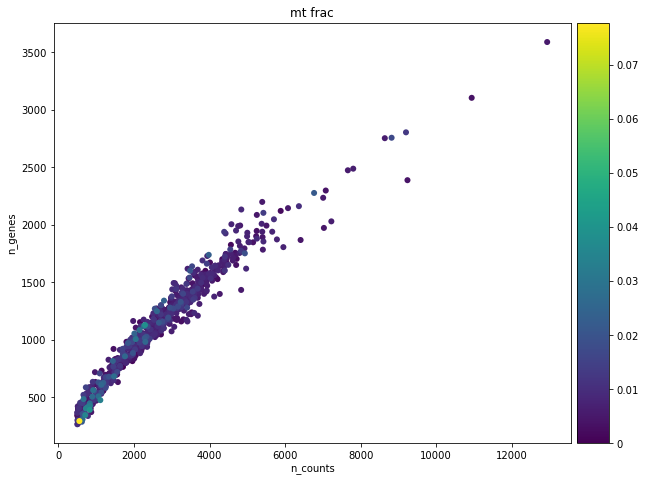

/Users/ann/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


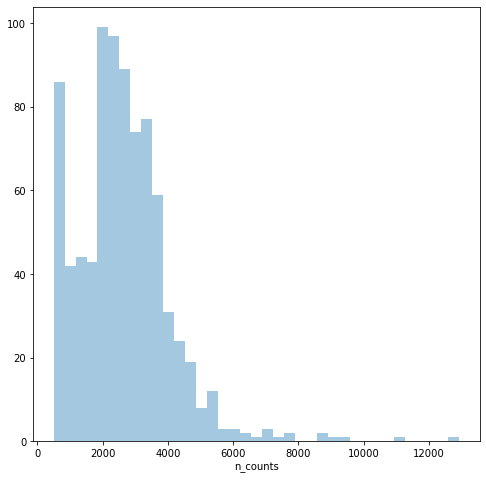

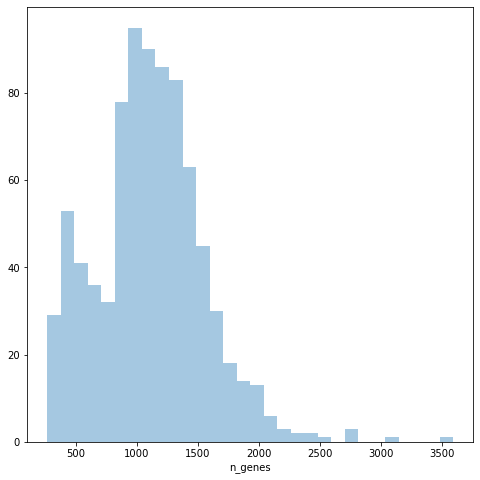

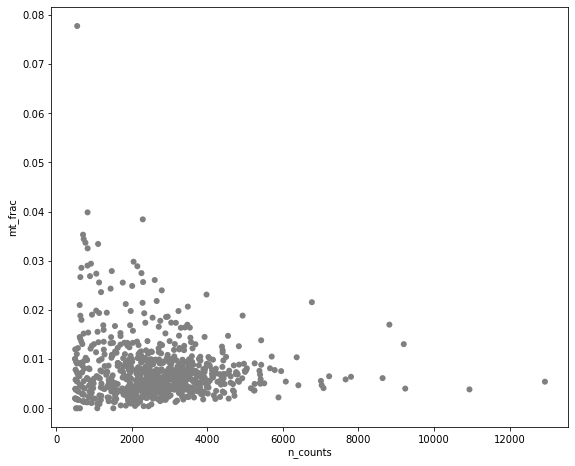

... storing 'dataset' as categorical
... storing 'condition' as categorical
... storing 'batch' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical


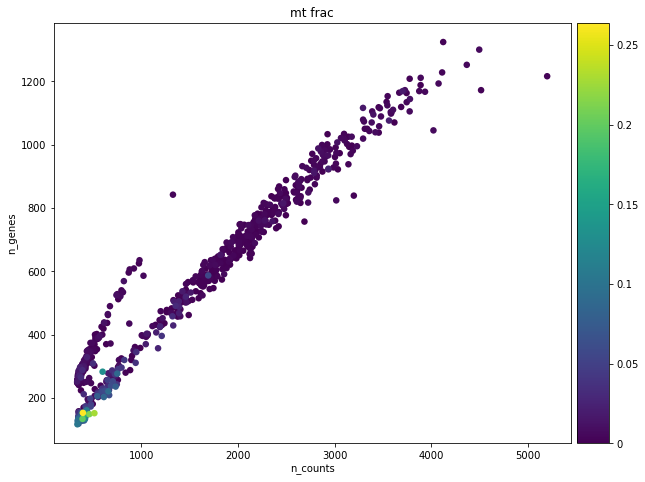

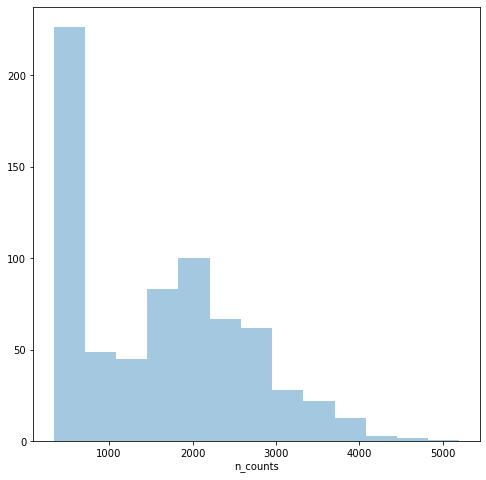

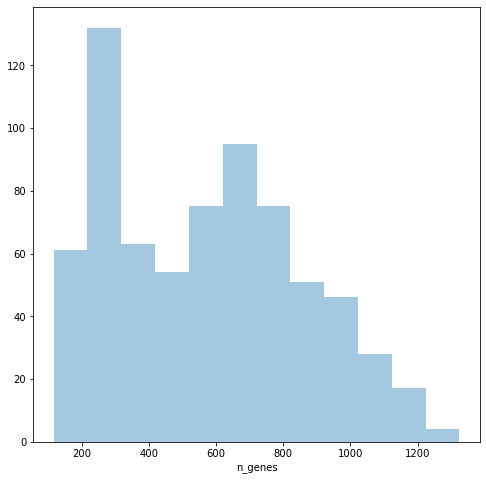

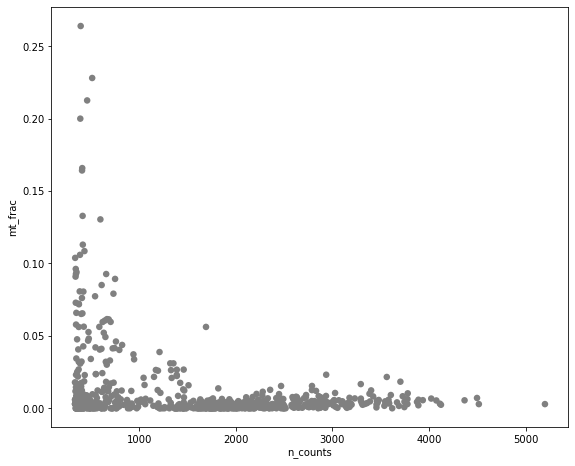

... storing 'dataset' as categorical
... storing 'condition' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical
... storing 'batch' as categorical


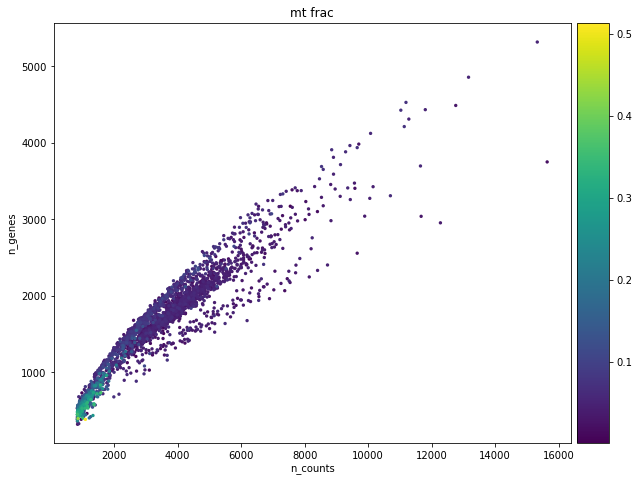

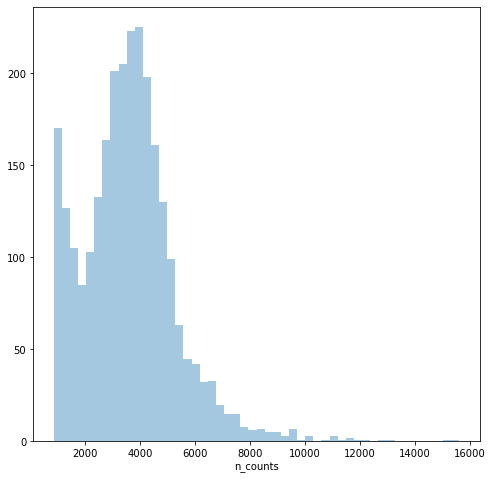

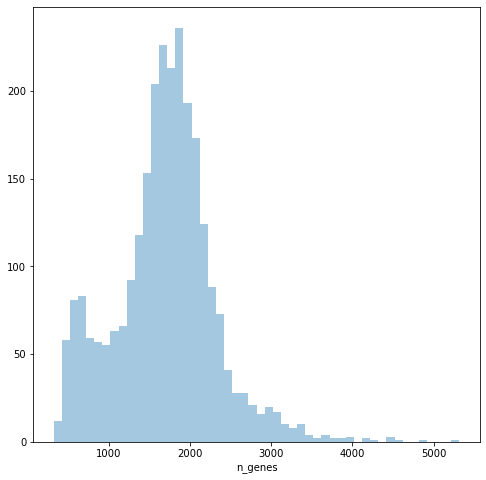

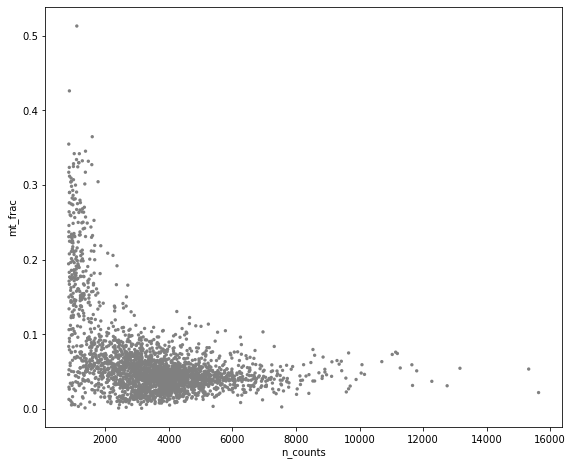

... storing 'dataset' as categorical
... storing 'condition' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical
... storing 'batch' as categorical


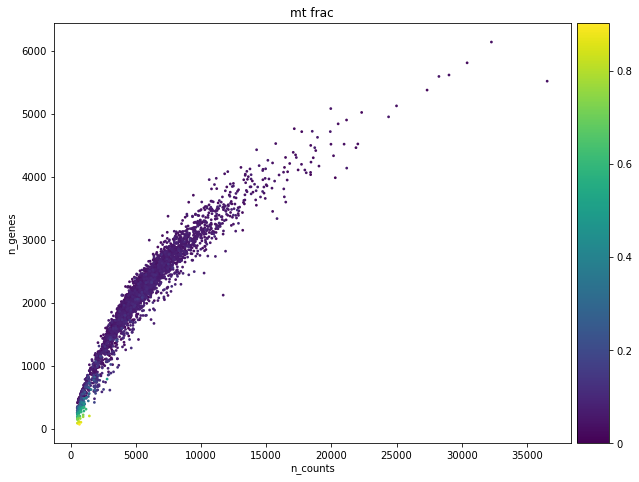

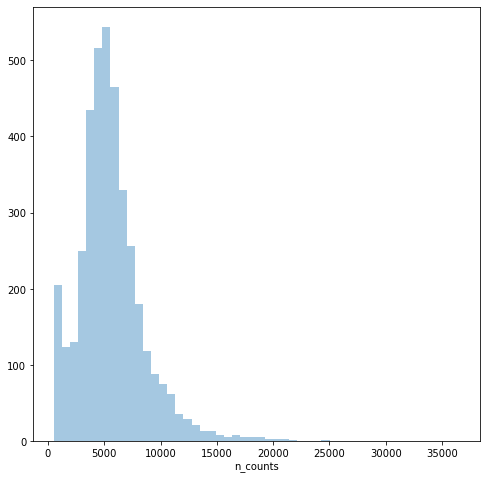

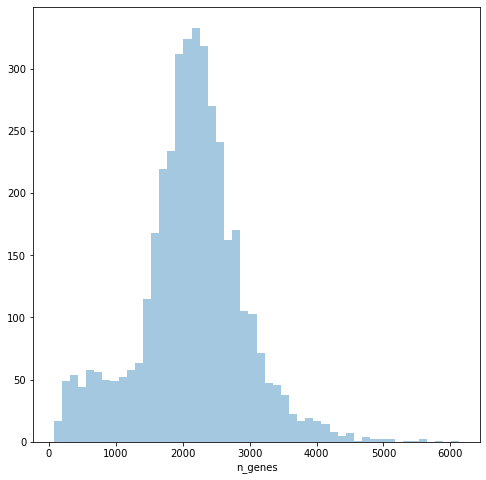

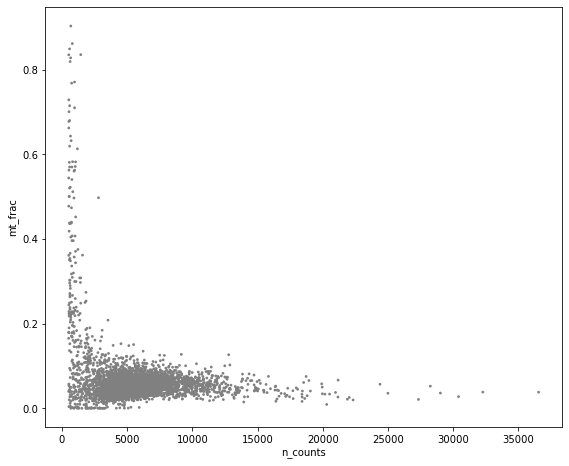

... storing 'dataset' as categorical
... storing 'condition' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical
... storing 'batch' as categorical


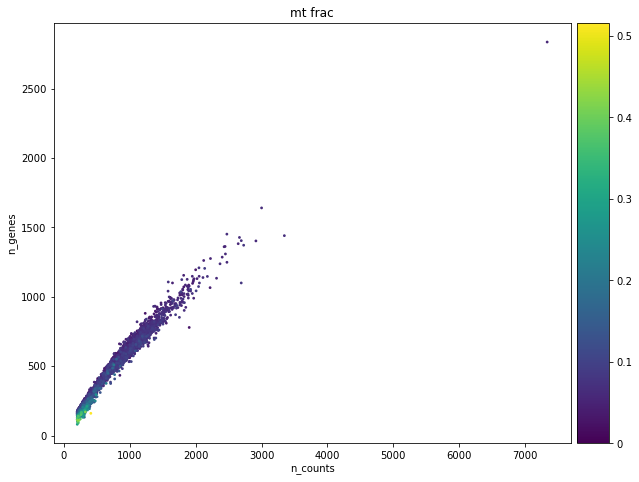

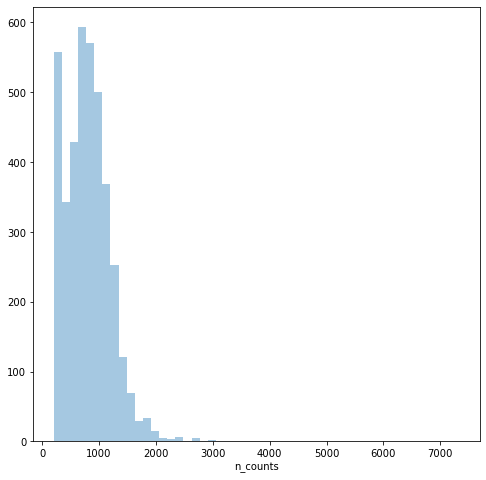

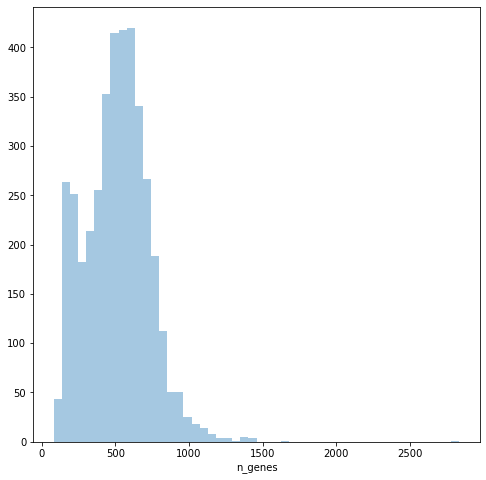

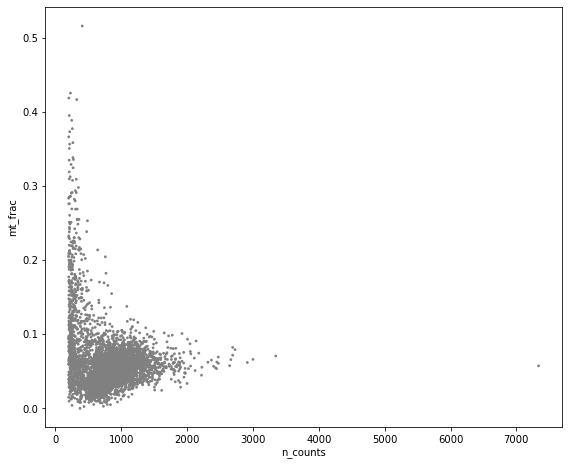

... storing 'condition' as categorical
... storing 'dataset' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical
... storing 'batch' as categorical


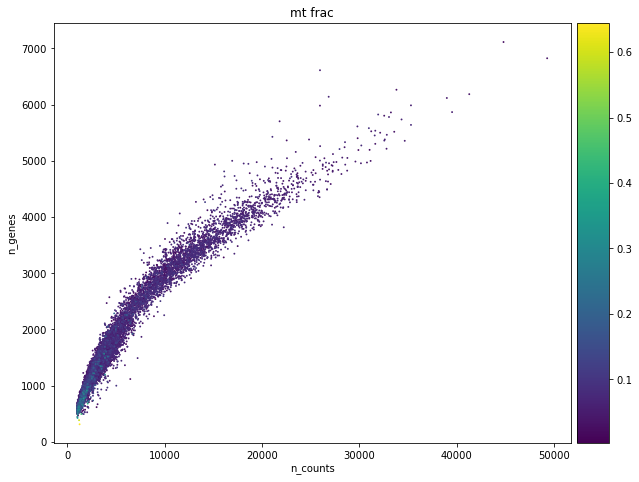

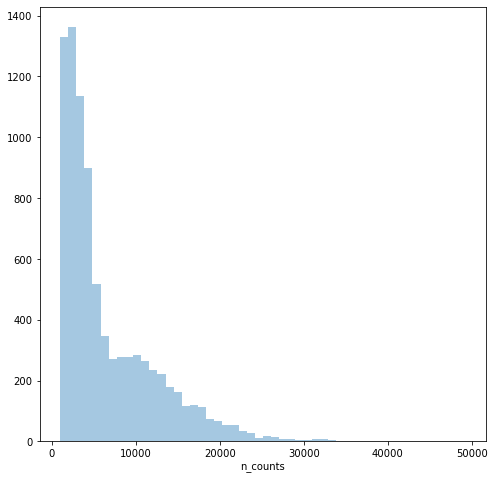

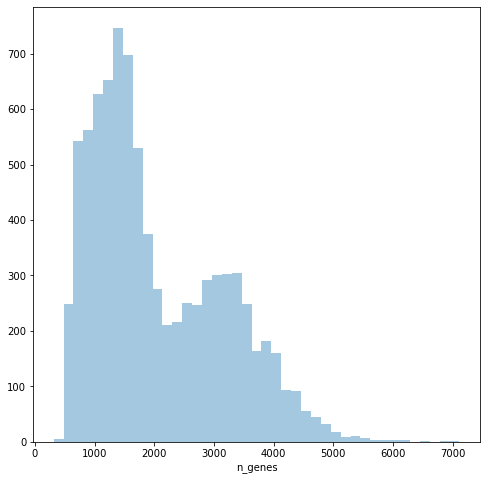

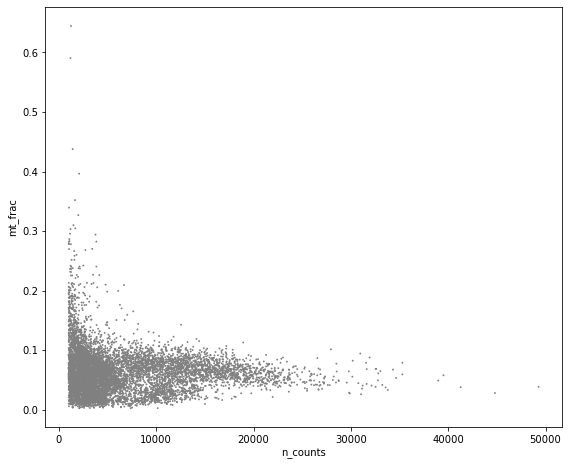

... storing 'condition' as categorical
... storing 'dataset' as categorical
... storing 'injury' as categorical
... storing 'species' as categorical
... storing 'batch' as categorical


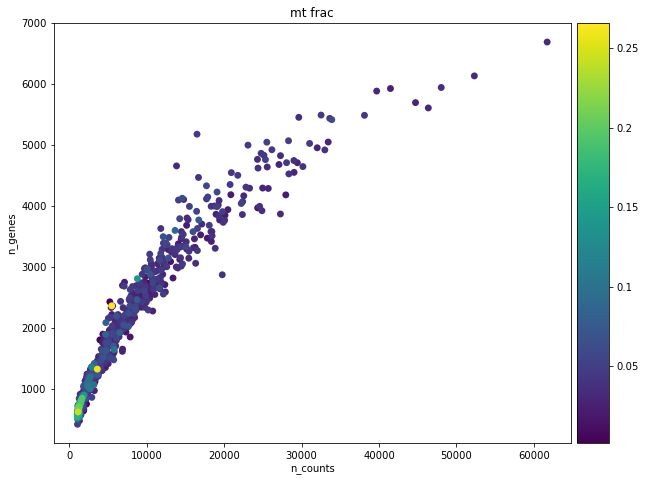

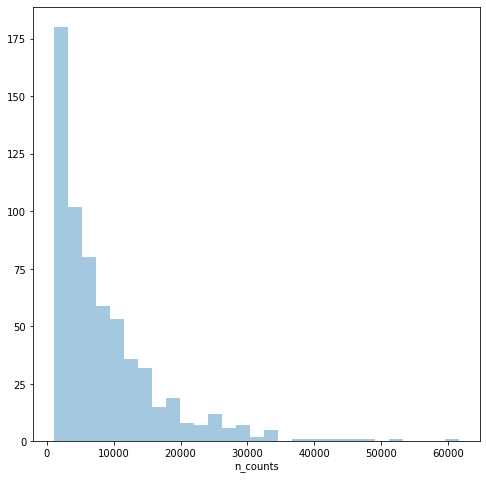

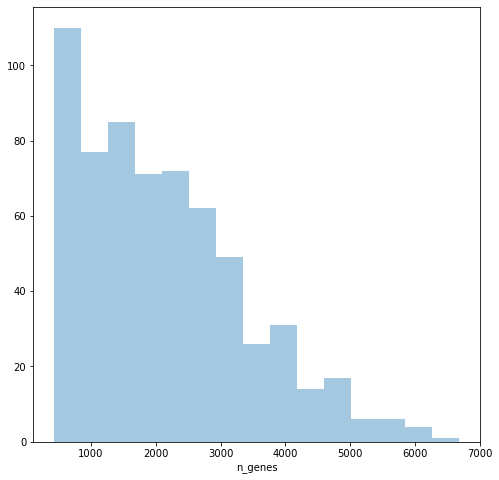

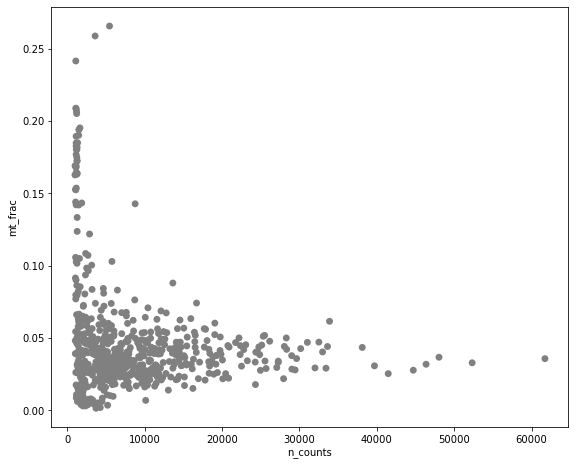

... storing 'dataset' as categorical
... storing 'batch' as categorical
... storing 'condition' as categorical
... storing 'species' as categorical
... storing 'injury' as categorical


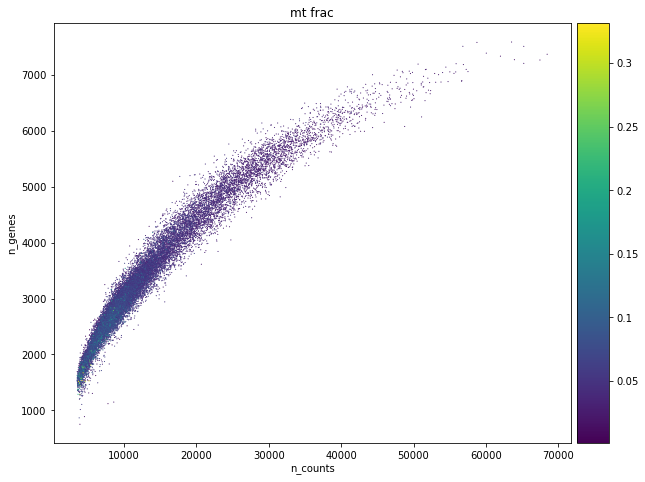

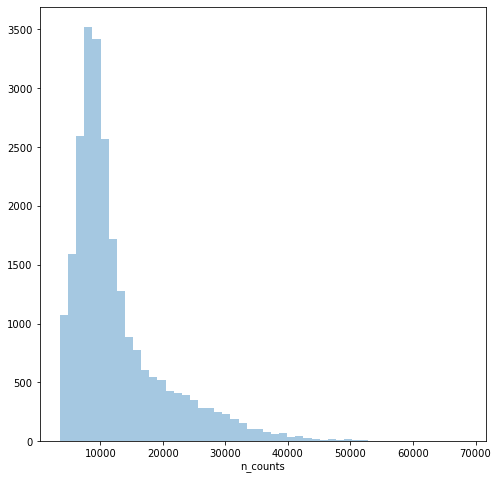

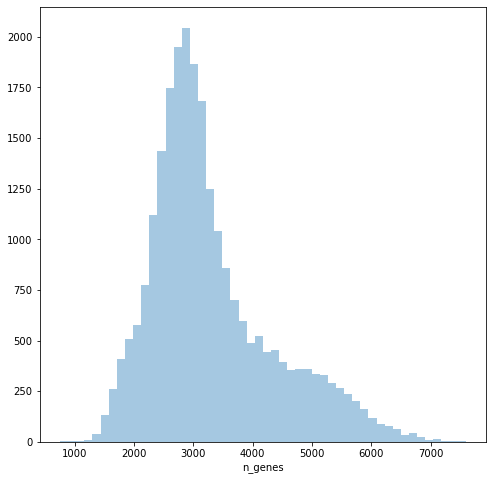

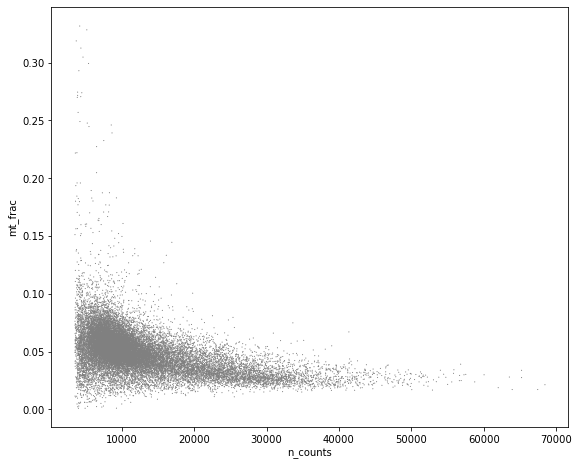

In [12]:
#generate scatterplots and histograms for all adatas
for adata in adatas:
    p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
    p2 = sb.distplot(adata.obs['n_counts'], kde=False)
    plt.show()
    p3 = sb.distplot(adata.obs['n_genes'], kde=False)
    plt.show()
    p4 = sc.pl.scatter(adata, 'n_counts', 'mt_frac')


In [13]:
#create bimodel counts column in .obs for adatas with bimodel distribution

count_peaks = [750, 1000, 2000, 2000, 400, 6000, 'NA', 'NA']

for adata in range(8):
    if count_peaks[adata] == 'NA':
        adatas[adata].obs['bimodel_counts'] = 'None'
    else:
        for n in range(0, len(adatas[adata].obs.index)):
            #print(n)
            df = adatas[adata].obs.iloc[[n]]
            #print(df)
            rowname = list(df.index)
            rowname = rowname.pop(0)
            counts = df.loc[rowname, 'n_counts']
            #print(str(counts) + '\n')
            if counts <= count_peaks[adata]:
                adatas[adata].obs.loc[rowname, 'bimodel_counts'] = 'Peak 1'
            elif counts > count_peaks[adata]:
                adatas[adata].obs.loc[rowname, 'bimodel_counts'] = 'Peak 2'

In [14]:
#create bimodel genes column in .obs for adatas with bimodel distribution

gene_peaks = [800, 400, 1000, 1500, 300, 2250, 'NA', 'NA']

for adata in range(8):
    if gene_peaks[adata] == 'NA':
        adatas[adata].obs['bimodel_genes'] = 'None'
    else:
        for n in range(0, len(adatas[adata].obs.index)):
            df = adatas[adata].obs.iloc[[n]]
            rowname = list(df.index)
            rowname = rowname.pop(0)
            gene = df.loc[rowname, 'n_genes']
            if gene <= gene_peaks[adata]:
                adatas[adata].obs.loc[rowname, 'bimodel_genes'] = 'Peak 1'
            elif gene > gene_peaks[adata]:
                adatas[adata].obs.loc[rowname, 'bimodel_genes'] = 'Peak 2'

In [15]:
#[adataANT17, adataWT17, adataANTsi21, adatamANTsi21, adatamANT21, adata20MNM, adata20ZNM, adataYAP]

# Filter cells according to identified QC thresholds/outliers (no gene filtering yet)
mtfrac = [0.025, 0.1, 0.2, 0.25, 0.2, 0.2, 0.1, 0.1]

for adata in adatas:
    n_counts = np.array(adata.obs['n_counts'])
    n_genes = np.array(adata.obs['n_genes'])
    Q3c = np.percentile(n_counts, 75)
    Q1c = np.percentile(n_counts, 25)
    IQRc = Q3c - Q1c
    maxc = (IQRc * 1.5) + Q3c
    minc = Q1c - (IQRc * 1.5)  
    Q3g = np.percentile(n_genes, 75)
    Q1g = np.percentile(n_genes, 25)
    IQRg = Q3g - Q1g
    maxg = (IQRg * 1.5) + Q3g
    ming = Q1g - (IQRg * 1.5)
    print('Total number of cells: {:d}'.format(adata.n_obs))
    sc.pp.filter_cells(adata, min_counts = minc)
    print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
    sc.pp.filter_cells(adata, max_counts = maxc)
    print('Number of cells after max count filter: {:d}'.format(adata.n_obs))
    sc.pp.filter_cells(adata, min_genes = ming)
    sc.pp.filter_cells(adata, max_genes = maxg)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
    
    
for n in range(8):    
    print('Number of cells before MT filter: {:d}'.format(adatas[n].n_obs))
    adatas[n] = adatas[n][adatas[n].obs['mt_frac'] < float(mtfrac[n])]
    print('Number of cells after MT filter: {:d}'.format(adatas[n].n_obs))

Total number of cells: 825
Number of cells after min count filter: 825
filtered out 19 cells that have more than 5756.5 counts
Number of cells after max count filter: 806
filtered out 1 cells that have more than 2154.5 genes expressed
Number of cells after gene filter: 805
Total number of cells: 701
Number of cells after min count filter: 701
filtered out 1 cells that have more than 4935.0 counts
Number of cells after max count filter: 700
Number of cells after gene filter: 700
Total number of cells: 2652
Number of cells after min count filter: 2652
filtered out 68 cells that have more than 7455.875 counts
Number of cells after max count filter: 2584
filtered out 2 cells that have less than 355.375 genes expressed
filtered out 20 cells that have more than 3044.375 genes expressed
Number of cells after gene filter: 2562
Total number of cells: 3952
Number of cells after min count filter: 3952
filtered out 166 cells that have more than 11492.125 counts
Number of cells after max count filt

In [16]:
#Concatenate adata20Mouse
adata17 = adataANT17.copy()
adata17 = adataANT17.concatenate(adataWT17, batch_key='placeholder', join='outer')
adata17.obs.drop(columns=['placeholder'], inplace=True)
adata17.obs_names = [c.split("-")[0] for c in adata17.obs_names]
adata17.obs_names_make_unique(join='_')

/Users/ann/opt/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:868: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "obs")


In [17]:
#Concatenate adata20Mouse
adata21 = adataANTsi21.copy()
adata21 = adata21.concatenate(adatamANTsi21, adatamANT21, batch_key='placeholder', join='outer')
adata21.obs.drop(columns=['placeholder'], inplace=True)
adata21.obs_names = [c.split("-")[0] for c in adata21.obs_names]
adata21.obs_names_make_unique(join='_')

In [18]:
adatas2 = [adata17, adata21, adata20MNM, adata20MNMic,adataYAP]
gene_filt = [5, 20, 20, 5, 20]

for n in range(5): 
    print('Total number of genes: {:d}'.format(adatas2[n].n_vars))
    sc.pp.filter_genes(adatas2[n], min_cells=gene_filt[n])
    print('Number of genes after cell filter: {:d}'.format(adatas2[n].n_vars))

    #print('Number of cells before MT filter: {:d}'.format(adatas[n].n_obs))
   # adatas[n] = adatas[n][adatas[n].obs['mt_frac'] < float(mtfrac[n])]
    #print('Number of cells after MT filter: {:d}'.format(adatas[n].n_obs))

Total number of genes: 27998
filtered out 15477 genes that are detected in less than 5 cells
Number of genes after cell filter: 12521
Total number of genes: 31477
filtered out 17211 genes that are detected in less than 20 cells
Number of genes after cell filter: 14266
Total number of genes: 27998
filtered out 13906 genes that are detected in less than 20 cells
Number of genes after cell filter: 14092
Total number of genes: 27998
filtered out 15839 genes that are detected in less than 5 cells
Number of genes after cell filter: 12159
Total number of genes: 18478
filtered out 2505 genes that are detected in less than 20 cells
Number of genes after cell filter: 15973


In [19]:
#Concatenate adata
adata = adata17.copy()
adata = adata.concatenate(adata21, adata20MNM, adata20MNMic, adataYAP, batch_key='placeholder', join='outer')
adata.obs.drop(columns=['placeholder'], inplace=True)
adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
adata.obs_names_make_unique(join='_')

/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/merge.py:810: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  concat_annot = pd.concat(


In [20]:
adata

AnnData object with n_obs × n_vars = 43107 × 17006
    obs: 'batch', 'bimodel_counts', 'bimodel_genes', 'condition', 'dataset', 'injury', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'species'
    var: 'gene_id-0', 'n_cells-0', 'n_cells-1', 'gene_id-0-1', 'gene_id-1-1', 'gene_id-2-1', 'gene_id-2', 'n_cells-2', 'gene_id-3', 'n_cells-3', 'n_cells-4'

In [21]:
#remove all NaNs
adata.X = np.nan_to_num(adata.X, nan=0.0, copy = False)
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 5., 0.],
       [0., 0., 0., ..., 4., 3., 0.],
       [2., 0., 0., ..., 3., 6., 0.]], dtype=float32)

In [22]:
#separate all anndatas for normalization
adataANT2d = adata[adata.obs["batch"] == "ANT_2d", :]
adataANT6w = adata[adata.obs["batch"] == "ANT_6wks", :]
adataANTsi2d = adata[adata.obs["batch"] == "ANTsi_2d", :]
adataANTsi3w = adata[adata.obs["batch"] == "ANTsi_3wks", :]
adataWT = adata[adata.obs["batch"] == "WT", :]
adataR1 = adata[adata.obs["batch"] == "Rueda_1", :]
adataR2 = adata[adata.obs["batch"] == "Rueda_2", :]
adataR3 = adata[adata.obs["batch"] == "Rueda_3", :]
adataMG = adata[adata.obs["batch"] == "MG", :]
adataMic = adata[adata.obs["batch"] == "Microglia", :]
adatas3 = [adataANT2d, adataANT6w, adataANTsi2d, adataANTsi3w, adataWT, adataR1, adataR2, adataR3, adataMG, adataMic]

In [23]:
#Perform a clustering for scran normalization in clusters
for adata in adatas3:
    print(adata.X)
    adata.layers["counts"] = adata.X.copy() #raw count data
    sc.pp.normalize_total(adata, target_sum=10000) #change function bc deprecated
    print(adata.layers['counts'])
    print(adata.X)
    print('____________________________________________________________________\n')
    #sc.pp.log1p(adata)
    #adata.raw = adata

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [2. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]]
normalizing counts per cell
    finished (0:00:00)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [2. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]]
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        4.6511626 0.        ... 0.        0.        4.6511626]
 [6.169031  0.        0.        ... 0.        0.        0.       ]
 ...
 [8.193363  0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        4.008016  0.        ... 0.        0.        0.       ]]
____________________________________________________________________

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
nor

In [24]:
#Perform a clustering for scran normalization in clusters
for adata in adatas3:
    sc.pp.log1p(adata)
    print(adata.X)
    adata.raw = adata

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.7318614 0.        ... 0.        0.        1.7318614]
 [1.9697706 0.        0.        ... 0.        0.        0.       ]
 ...
 [2.2184818 0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.6110399 0.        ... 0.        0.        0.       ]]
[[0.        0.        0.        ... 2.345066  0.        0.       ]
 [0.        0.        0.        ... 0.        2.692876  0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        3.423402  0.       ]
 [0.        0.        0.        ... 0.        2.6688116 0.       ]
 [0.        0.        0.        ... 3.222724  0.        0.       ]]
[[2.4870176 0.        0.        ... 0.        0.        0.       ]
 [1.2176547 0.        0.        ... 2.5569377 1.7506781 0.       ]
 [0.        0.        0.        ... 3.1648128 1.56

In [25]:
adataJor = adataANT2d.copy()
adataJor = adataJor.concatenate(adataANT6w, adataANTsi2d, adataANTsi3w, adataWT)

adataR = adataR1.copy()
adataR = adataR.concatenate(adataR2, adataR3)

adataH = adataMG.copy()
adataH = adataH.concatenate(adataMic)

adatas2 = [adataJor, adataR, adataH]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  string_cols = [
... storing 'bimodel_counts' as categorical
... storing 'bimodel_genes' as categorical
... storing 'condition' as categorical
... storing 'dataset' as categorical


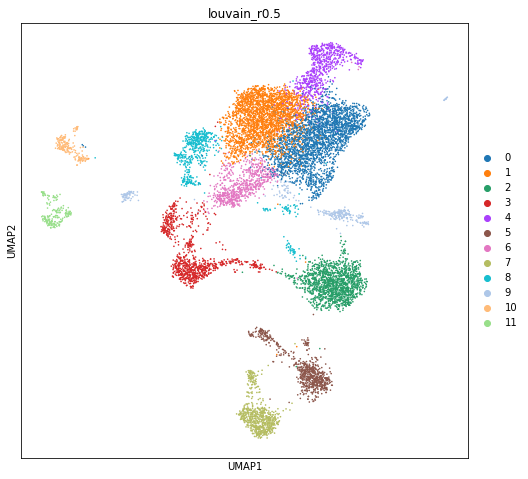

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:03)


/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  string_cols = [
... storing 'bimodel_counts' as categorical
... storing 'bimodel_genes' as categorical
... storing 'condition' as categorical
... storing 'dataset' as categorical


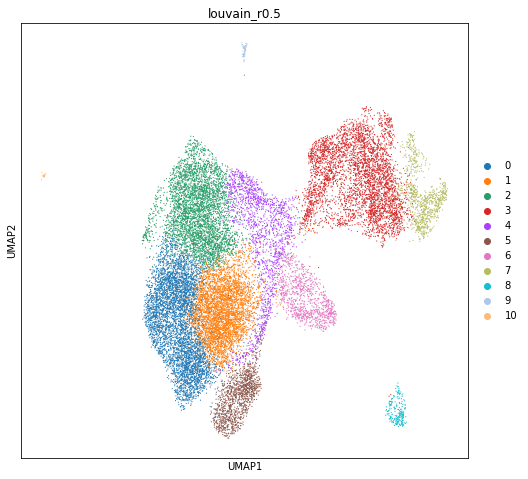

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  string_cols = [
... storing 'bimodel_counts' as categorical
... storing 'bimodel_genes' as categorical
... storing 'condition' as categorical
... storing 'dataset' as categorical


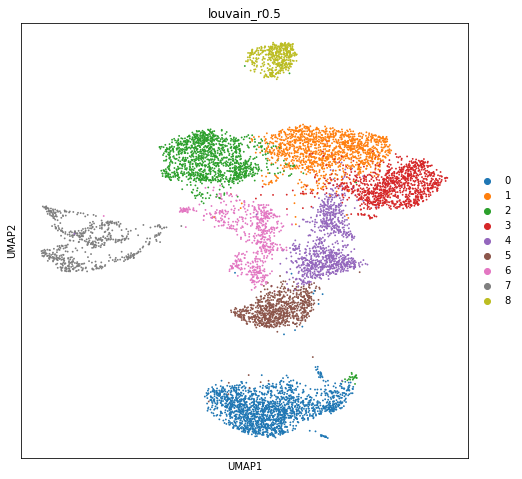

In [26]:
for adata in adatas2:
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)
    sc.pl.umap(adata, color='louvain_r0.5')


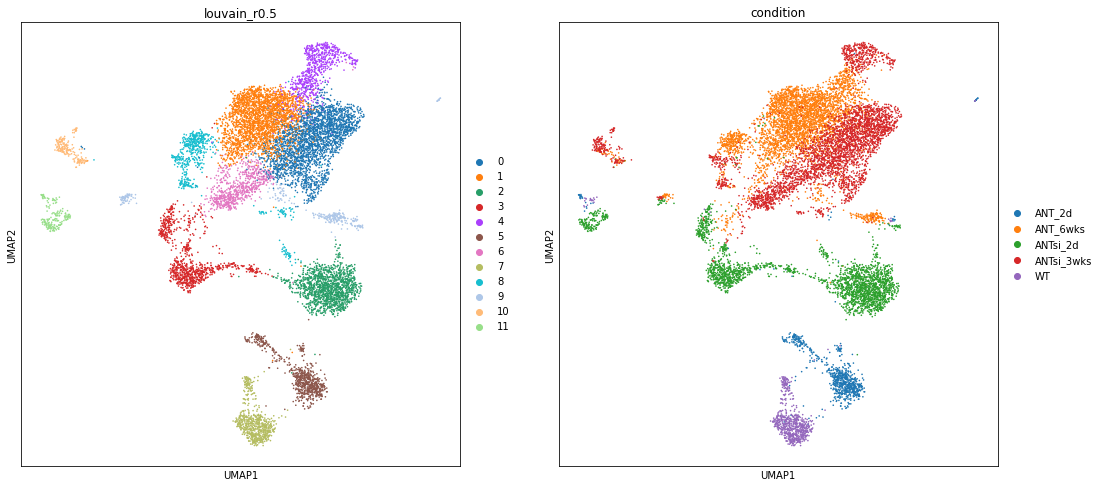

In [27]:
sc.pl.umap(adataJor, color=['louvain_r0.5', 'condition'])


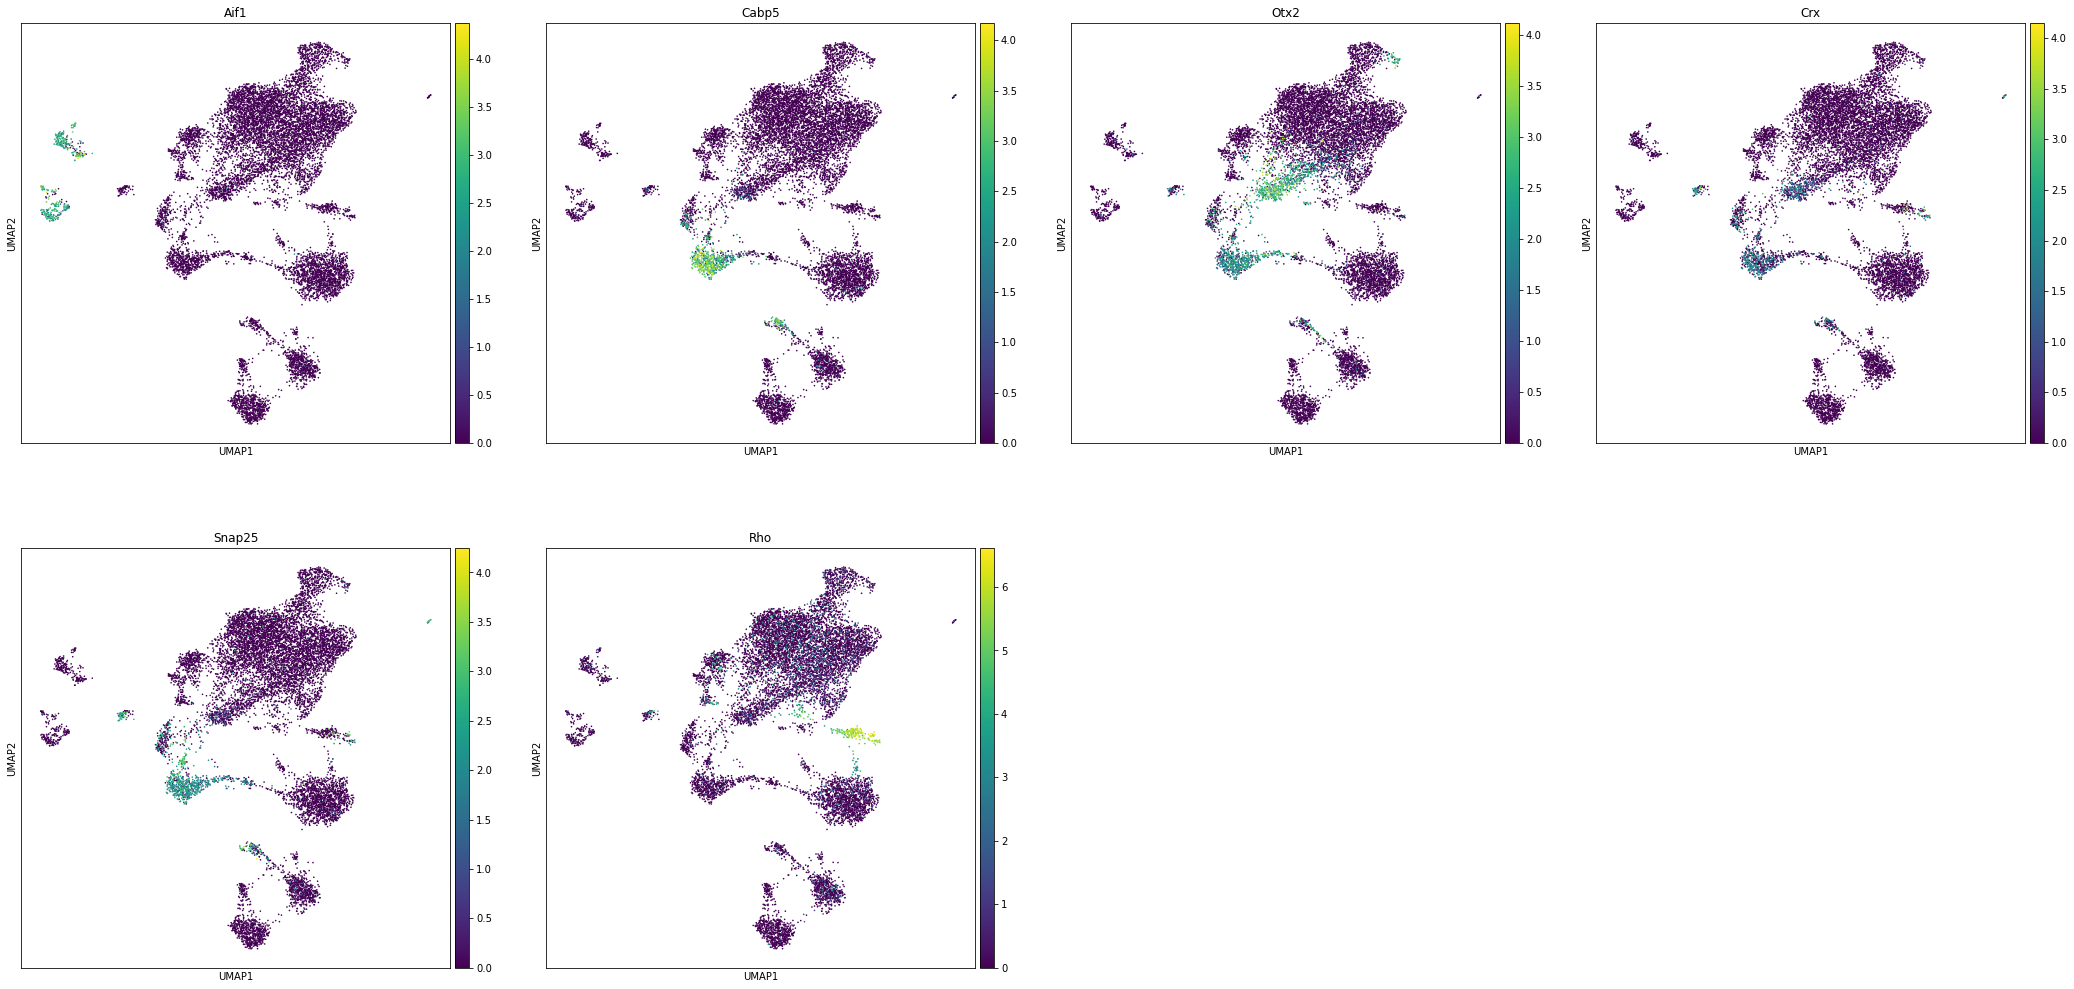

In [28]:
sc.pl.umap(adataJor, color = ['Aif1', 'Cabp5', 'Otx2', 'Crx', 'Snap25', 'Rho'])

In [29]:
adataJor.rename_categories('louvain_r0.5', ['ANTsi_3wks','ANT_6wks', 'ANTsi_2d','MG_Neurons_ANTsi2d', 'split', 'ANT_2d','MG_Neurons_ANTsi3wk','WT', 'split2','Rods','Microglia2', 'Microglia'])

In [30]:
adataJor.obs['louvain_r0.5'].replace({'Microglia2':'Microglia', 'split2':'split'}, inplace=True)


In [31]:
for n in range(11545):
    print(n)
    df = adataJor.obs.iloc[[n]]
    rowname = list(df.index)
    rowname = rowname.pop(0)
    cell = df.loc[rowname, 'louvain_r0.5']
    cond = df.loc[rowname, 'condition']   
    print(cell)
    print(cond)
    if cell == 'split':
        adataJor.obs.loc[rowname, 'newCell'] = cond
        print('a')
    else:
        adataJor.obs.loc[rowname, 'newCell'] = cell
        print('b')

0
ANT_2d
ANT_2d
b
1
ANT_2d
ANT_2d
b
2
ANT_2d
ANT_2d
b
3
Microglia
ANT_2d
b
4
ANT_2d
ANT_2d
b
5
Rods
ANT_2d
b
6
ANT_2d
ANT_2d
b
7
ANT_2d
ANT_2d
b
8
ANT_2d
ANT_2d
b
9
ANTsi_2d
ANT_2d
b
10
ANT_2d
ANT_2d
b
11
ANT_2d
ANT_2d
b
12
ANT_2d
ANT_2d
b
13
ANT_2d
ANT_2d
b
14
ANT_2d
ANT_2d
b
15
ANT_2d
ANT_2d
b
16
ANT_2d
ANT_2d
b
17
WT
ANT_2d
b
18
ANT_2d
ANT_2d
b
19
ANT_2d
ANT_2d
b
20
ANT_2d
ANT_2d
b
21
ANT_2d
ANT_2d
b
22
WT
ANT_2d
b
23
ANT_2d
ANT_2d
b
24
ANT_2d
ANT_2d
b
25
ANT_2d
ANT_2d
b
26
ANT_2d
ANT_2d
b
27
ANT_2d
ANT_2d
b
28
ANT_2d
ANT_2d
b
29
ANT_2d
ANT_2d
b
30
ANT_2d
ANT_2d
b
31
ANT_2d
ANT_2d
b
32
ANT_2d
ANT_2d
b
33
ANT_2d
ANT_2d
b
34
ANT_2d
ANT_2d
b
35
ANT_2d
ANT_2d
b
36
ANT_2d
ANT_2d
b
37
ANT_2d
ANT_2d
b
38
ANT_2d
ANT_2d
b
39
ANT_2d
ANT_2d
b
40
ANT_2d
ANT_2d
b
41
ANT_2d
ANT_2d
b
42
ANT_2d
ANT_2d
b
43
ANT_2d
ANT_2d
b
44
ANT_2d
ANT_2d
b
45
ANT_2d
ANT_2d
b
46
ANT_2d
ANT_2d
b
47
ANT_2d
ANT_2d
b
48
ANT_2d
ANT_2d
b
49
ANT_2d
ANT_2d
b
50
ANT_2d
ANT_2d
b
51
ANT_2d
ANT_2d
b
52
ANT_2d
ANT_2d
b
53
ANT_2

ANT_2d
ANT_2d
b
455
ANT_2d
ANT_2d
b
456
ANT_2d
ANT_2d
b
457
ANT_2d
ANT_2d
b
458
ANT_2d
ANT_2d
b
459
ANT_2d
ANT_2d
b
460
ANT_2d
ANT_2d
b
461
ANT_2d
ANT_2d
b
462
ANT_2d
ANT_2d
b
463
ANT_2d
ANT_2d
b
464
ANT_2d
ANT_2d
b
465
ANT_2d
ANT_2d
b
466
ANT_2d
ANT_2d
b
467
ANT_2d
ANT_2d
b
468
ANT_2d
ANT_2d
b
469
ANT_2d
ANT_2d
b
470
split
ANT_2d
a
471
split
ANT_2d
a
472
split
ANT_2d
a
473
split
ANT_2d
a
474
ANT_2d
ANT_2d
b
475
ANT_2d
ANT_2d
b
476
ANT_2d
ANT_2d
b
477
ANT_2d
ANT_2d
b
478
ANT_2d
ANT_2d
b
479
ANT_2d
ANT_2d
b
480
ANT_2d
ANT_2d
b
481
ANT_2d
ANT_2d
b
482
ANT_2d
ANT_2d
b
483
ANT_2d
ANT_2d
b
484
ANT_2d
ANT_2d
b
485
ANT_2d
ANT_2d
b
486
ANT_2d
ANT_2d
b
487
ANT_2d
ANT_2d
b
488
ANT_2d
ANT_2d
b
489
ANT_2d
ANT_2d
b
490
ANT_2d
ANT_2d
b
491
ANT_2d
ANT_2d
b
492
ANT_2d
ANT_2d
b
493
ANT_2d
ANT_2d
b
494
ANT_2d
ANT_2d
b
495
ANT_2d
ANT_2d
b
496
ANT_2d
ANT_2d
b
497
ANT_2d
ANT_2d
b
498
ANT_2d
ANT_2d
b
499
ANT_2d
ANT_2d
b
500
ANT_2d
ANT_2d
b
501
ANT_2d
ANT_2d
b
502
ANT_2d
ANT_2d
b
503
ANT_2d
ANT_2d
b
504
ANT_

b
925
MG_Neurons_ANTsi3wk
ANT_6wks
b
926
ANT_6wks
ANT_6wks
b
927
ANT_6wks
ANT_6wks
b
928
ANT_6wks
ANT_6wks
b
929
split
ANT_6wks
a
930
split
ANT_6wks
a
931
ANT_6wks
ANT_6wks
b
932
ANT_6wks
ANT_6wks
b
933
split
ANT_6wks
a
934
ANTsi_3wks
ANT_6wks
b
935
ANT_6wks
ANT_6wks
b
936
Rods
ANT_6wks
b
937
MG_Neurons_ANTsi3wk
ANT_6wks
b
938
ANTsi_3wks
ANT_6wks
b
939
ANTsi_3wks
ANT_6wks
b
940
ANT_6wks
ANT_6wks
b
941
ANT_6wks
ANT_6wks
b
942
split
ANT_6wks
a
943
ANT_6wks
ANT_6wks
b
944
ANTsi_3wks
ANT_6wks
b
945
ANT_6wks
ANT_6wks
b
946
ANT_6wks
ANT_6wks
b
947
ANT_6wks
ANT_6wks
b
948
ANT_6wks
ANT_6wks
b
949
ANT_6wks
ANT_6wks
b
950
ANT_6wks
ANT_6wks
b
951
ANT_6wks
ANT_6wks
b
952
ANT_6wks
ANT_6wks
b
953
ANT_6wks
ANT_6wks
b
954
ANT_6wks
ANT_6wks
b
955
split
ANT_6wks
a
956
split
ANT_6wks
a
957
split
ANT_6wks
a
958
ANT_6wks
ANT_6wks
b
959
split
ANT_6wks
a
960
ANT_6wks
ANT_6wks
b
961
ANT_6wks
ANT_6wks
b
962
ANT_6wks
ANT_6wks
b
963
ANT_6wks
ANT_6wks
b
964
ANT_6wks
ANT_6wks
b
965
ANT_6wks
ANT_6wks
b
966
ANT_6wks

ANTsi_3wks
ANT_6wks
b
1302
ANT_6wks
ANT_6wks
b
1303
ANTsi_3wks
ANT_6wks
b
1304
ANT_6wks
ANT_6wks
b
1305
split
ANT_6wks
a
1306
ANT_6wks
ANT_6wks
b
1307
split
ANT_6wks
a
1308
ANT_6wks
ANT_6wks
b
1309
ANT_6wks
ANT_6wks
b
1310
ANT_6wks
ANT_6wks
b
1311
ANT_6wks
ANT_6wks
b
1312
ANT_6wks
ANT_6wks
b
1313
MG_Neurons_ANTsi2d
ANT_6wks
b
1314
split
ANT_6wks
a
1315
ANT_6wks
ANT_6wks
b
1316
ANT_6wks
ANT_6wks
b
1317
ANT_6wks
ANT_6wks
b
1318
ANT_6wks
ANT_6wks
b
1319
split
ANT_6wks
a
1320
ANT_6wks
ANT_6wks
b
1321
ANT_6wks
ANT_6wks
b
1322
ANT_6wks
ANT_6wks
b
1323
ANT_6wks
ANT_6wks
b
1324
Rods
ANT_6wks
b
1325
ANTsi_3wks
ANT_6wks
b
1326
ANTsi_3wks
ANT_6wks
b
1327
ANT_6wks
ANT_6wks
b
1328
ANTsi_3wks
ANT_6wks
b
1329
ANT_6wks
ANT_6wks
b
1330
Rods
ANT_6wks
b
1331
ANT_6wks
ANT_6wks
b
1332
ANT_6wks
ANT_6wks
b
1333
ANTsi_3wks
ANT_6wks
b
1334
ANT_6wks
ANT_6wks
b
1335
ANTsi_3wks
ANT_6wks
b
1336
ANT_6wks
ANT_6wks
b
1337
ANT_6wks
ANT_6wks
b
1338
ANT_6wks
ANT_6wks
b
1339
ANTsi_3wks
ANT_6wks
b
1340
ANT_6wks
ANT_6wks
b

ANT_6wks
ANT_6wks
b
1682
ANT_6wks
ANT_6wks
b
1683
ANT_6wks
ANT_6wks
b
1684
split
ANT_6wks
a
1685
ANT_6wks
ANT_6wks
b
1686
ANT_6wks
ANT_6wks
b
1687
ANT_6wks
ANT_6wks
b
1688
ANT_6wks
ANT_6wks
b
1689
MG_Neurons_ANTsi3wk
ANT_6wks
b
1690
ANTsi_3wks
ANT_6wks
b
1691
ANTsi_3wks
ANT_6wks
b
1692
Rods
ANT_6wks
b
1693
ANT_6wks
ANT_6wks
b
1694
split
ANT_6wks
a
1695
split
ANT_6wks
a
1696
ANT_6wks
ANT_6wks
b
1697
ANT_6wks
ANT_6wks
b
1698
ANT_6wks
ANT_6wks
b
1699
Microglia
ANT_6wks
b
1700
ANT_6wks
ANT_6wks
b
1701
ANT_6wks
ANT_6wks
b
1702
ANT_6wks
ANT_6wks
b
1703
ANTsi_3wks
ANT_6wks
b
1704
split
ANT_6wks
a
1705
split
ANT_6wks
a
1706
split
ANT_6wks
a
1707
ANT_6wks
ANT_6wks
b
1708
ANT_6wks
ANT_6wks
b
1709
ANTsi_3wks
ANT_6wks
b
1710
Rods
ANT_6wks
b
1711
ANT_6wks
ANT_6wks
b
1712
ANT_6wks
ANT_6wks
b
1713
ANT_6wks
ANT_6wks
b
1714
ANT_6wks
ANT_6wks
b
1715
ANT_6wks
ANT_6wks
b
1716
ANT_6wks
ANT_6wks
b
1717
ANT_6wks
ANT_6wks
b
1718
ANT_6wks
ANT_6wks
b
1719
ANTsi_3wks
ANT_6wks
b
1720
ANT_6wks
ANT_6wks
b
1721
Rods

ANT_6wks
ANT_6wks
b
2064
ANT_6wks
ANT_6wks
b
2065
MG_Neurons_ANTsi3wk
ANT_6wks
b
2066
ANT_6wks
ANT_6wks
b
2067
ANT_6wks
ANT_6wks
b
2068
split
ANT_6wks
a
2069
ANT_6wks
ANT_6wks
b
2070
ANT_6wks
ANT_6wks
b
2071
split
ANT_6wks
a
2072
ANT_6wks
ANT_6wks
b
2073
ANT_6wks
ANT_6wks
b
2074
ANTsi_3wks
ANT_6wks
b
2075
ANT_6wks
ANT_6wks
b
2076
ANT_6wks
ANT_6wks
b
2077
ANT_6wks
ANT_6wks
b
2078
split
ANT_6wks
a
2079
ANT_6wks
ANT_6wks
b
2080
ANT_6wks
ANT_6wks
b
2081
ANT_6wks
ANT_6wks
b
2082
ANT_6wks
ANT_6wks
b
2083
Rods
ANT_6wks
b
2084
ANT_6wks
ANT_6wks
b
2085
ANTsi_3wks
ANT_6wks
b
2086
ANT_6wks
ANT_6wks
b
2087
ANT_6wks
ANT_6wks
b
2088
split
ANT_6wks
a
2089
ANT_6wks
ANT_6wks
b
2090
ANT_6wks
ANT_6wks
b
2091
ANT_6wks
ANT_6wks
b
2092
ANTsi_2d
ANT_6wks
b
2093
split
ANT_6wks
a
2094
ANT_6wks
ANT_6wks
b
2095
split
ANT_6wks
a
2096
ANT_6wks
ANT_6wks
b
2097
ANTsi_3wks
ANT_6wks
b
2098
ANT_6wks
ANT_6wks
b
2099
ANT_6wks
ANT_6wks
b
2100
ANT_6wks
ANT_6wks
b
2101
ANT_6wks
ANT_6wks
b
2102
ANT_6wks
ANT_6wks
b
2103
ANT_6

Rods
ANT_6wks
b
2441
ANT_6wks
ANT_6wks
b
2442
ANT_6wks
ANT_6wks
b
2443
split
ANT_6wks
a
2444
MG_Neurons_ANTsi2d
ANT_6wks
b
2445
ANT_6wks
ANT_6wks
b
2446
ANT_6wks
ANT_6wks
b
2447
split
ANT_6wks
a
2448
ANT_6wks
ANT_6wks
b
2449
split
ANT_6wks
a
2450
ANT_6wks
ANT_6wks
b
2451
ANT_6wks
ANT_6wks
b
2452
ANT_6wks
ANT_6wks
b
2453
ANTsi_3wks
ANT_6wks
b
2454
ANT_6wks
ANT_6wks
b
2455
ANT_6wks
ANT_6wks
b
2456
ANT_6wks
ANT_6wks
b
2457
ANT_6wks
ANT_6wks
b
2458
ANT_6wks
ANT_6wks
b
2459
ANT_6wks
ANT_6wks
b
2460
ANT_6wks
ANT_6wks
b
2461
ANT_6wks
ANT_6wks
b
2462
ANT_6wks
ANT_6wks
b
2463
ANT_6wks
ANT_6wks
b
2464
Rods
ANT_6wks
b
2465
ANTsi_3wks
ANT_6wks
b
2466
Rods
ANT_6wks
b
2467
ANT_6wks
ANT_6wks
b
2468
ANT_6wks
ANT_6wks
b
2469
ANT_6wks
ANT_6wks
b
2470
ANT_6wks
ANT_6wks
b
2471
Rods
ANT_6wks
b
2472
MG_Neurons_ANTsi2d
ANT_6wks
b
2473
ANTsi_3wks
ANT_6wks
b
2474
ANT_6wks
ANT_6wks
b
2475
ANTsi_3wks
ANT_6wks
b
2476
ANTsi_3wks
ANT_6wks
b
2477
ANT_6wks
ANT_6wks
b
2478
ANT_6wks
ANT_6wks
b
2479
ANT_6wks
ANT_6wks
b


ANT_6wks
b
2827
MG_Neurons_ANTsi2d
ANT_6wks
b
2828
ANT_6wks
ANT_6wks
b
2829
ANT_6wks
ANT_6wks
b
2830
ANT_6wks
ANT_6wks
b
2831
split
ANT_6wks
a
2832
split
ANT_6wks
a
2833
split
ANT_6wks
a
2834
split
ANT_6wks
a
2835
ANT_6wks
ANT_6wks
b
2836
ANTsi_3wks
ANT_6wks
b
2837
ANT_6wks
ANT_6wks
b
2838
split
ANT_6wks
a
2839
ANT_6wks
ANT_6wks
b
2840
ANT_6wks
ANT_6wks
b
2841
split
ANT_6wks
a
2842
ANTsi_3wks
ANT_6wks
b
2843
ANTsi_3wks
ANT_6wks
b
2844
ANT_6wks
ANT_6wks
b
2845
ANT_6wks
ANT_6wks
b
2846
split
ANT_6wks
a
2847
ANT_6wks
ANT_6wks
b
2848
MG_Neurons_ANTsi3wk
ANT_6wks
b
2849
ANTsi_3wks
ANT_6wks
b
2850
ANTsi_3wks
ANT_6wks
b
2851
ANT_6wks
ANT_6wks
b
2852
split
ANT_6wks
a
2853
ANT_6wks
ANT_6wks
b
2854
Rods
ANT_6wks
b
2855
ANT_6wks
ANT_6wks
b
2856
ANT_6wks
ANT_6wks
b
2857
ANT_6wks
ANT_6wks
b
2858
split
ANT_6wks
a
2859
MG_Neurons_ANTsi3wk
ANT_6wks
b
2860
split
ANT_6wks
a
2861
ANTsi_3wks
ANT_6wks
b
2862
ANTsi_3wks
ANT_6wks
b
2863
split
ANT_6wks
a
2864
ANT_6wks
ANT_6wks
b
2865
ANT_6wks
ANT_6wks
b
2866


ANT_6wks
ANT_6wks
b
3211
split
ANT_6wks
a
3212
ANT_6wks
ANT_6wks
b
3213
Rods
ANT_6wks
b
3214
ANT_6wks
ANT_6wks
b
3215
ANT_6wks
ANT_6wks
b
3216
ANT_6wks
ANT_6wks
b
3217
split
ANT_6wks
a
3218
ANT_6wks
ANT_6wks
b
3219
ANT_6wks
ANT_6wks
b
3220
ANT_6wks
ANT_6wks
b
3221
split
ANT_6wks
a
3222
ANT_6wks
ANT_6wks
b
3223
Rods
ANT_6wks
b
3224
ANT_6wks
ANT_6wks
b
3225
ANT_6wks
ANT_6wks
b
3226
ANT_6wks
ANT_6wks
b
3227
Microglia
ANT_6wks
b
3228
MG_Neurons_ANTsi2d
ANT_6wks
b
3229
split
ANT_6wks
a
3230
ANT_6wks
ANT_6wks
b
3231
ANT_6wks
ANT_6wks
b
3232
Rods
ANT_6wks
b
3233
ANT_6wks
ANT_6wks
b
3234
ANT_6wks
ANT_6wks
b
3235
ANT_6wks
ANT_6wks
b
3236
ANT_6wks
ANT_6wks
b
3237
ANT_6wks
ANT_6wks
b
3238
split
ANT_6wks
a
3239
ANT_6wks
ANT_6wks
b
3240
ANT_6wks
ANT_6wks
b
3241
split
ANT_6wks
a
3242
ANT_6wks
ANT_6wks
b
3243
ANT_6wks
ANT_6wks
b
3244
ANT_6wks
ANT_6wks
b
3245
ANT_6wks
ANT_6wks
b
3246
ANT_6wks
ANT_6wks
b
3247
split
ANT_6wks
a
3248
split
ANT_6wks
a
3249
ANT_6wks
ANT_6wks
b
3250
ANT_6wks
ANT_6wks
b
3251


Rods
ANT_6wks
b
3584
ANTsi_3wks
ANT_6wks
b
3585
ANT_6wks
ANT_6wks
b
3586
ANT_6wks
ANT_6wks
b
3587
split
ANT_6wks
a
3588
MG_Neurons_ANTsi2d
ANT_6wks
b
3589
split
ANT_6wks
a
3590
ANT_6wks
ANT_6wks
b
3591
ANT_6wks
ANT_6wks
b
3592
ANT_6wks
ANT_6wks
b
3593
ANT_6wks
ANT_6wks
b
3594
Rods
ANT_6wks
b
3595
ANT_6wks
ANT_6wks
b
3596
ANT_6wks
ANT_6wks
b
3597
ANT_6wks
ANT_6wks
b
3598
split
ANT_6wks
a
3599
ANT_6wks
ANT_6wks
b
3600
ANT_6wks
ANT_6wks
b
3601
ANT_6wks
ANT_6wks
b
3602
split
ANT_6wks
a
3603
ANT_6wks
ANT_6wks
b
3604
ANTsi_3wks
ANT_6wks
b
3605
ANT_6wks
ANT_6wks
b
3606
ANT_6wks
ANT_6wks
b
3607
split
ANT_6wks
a
3608
ANT_6wks
ANT_6wks
b
3609
ANT_6wks
ANT_6wks
b
3610
ANT_6wks
ANT_6wks
b
3611
MG_Neurons_ANTsi3wk
ANT_6wks
b
3612
ANT_6wks
ANT_6wks
b
3613
ANT_6wks
ANT_6wks
b
3614
ANT_6wks
ANT_6wks
b
3615
Rods
ANT_6wks
b
3616
ANT_6wks
ANT_6wks
b
3617
split
ANT_6wks
a
3618
ANT_6wks
ANT_6wks
b
3619
ANT_6wks
ANT_6wks
b
3620
Rods
ANT_6wks
b
3621
split
ANT_6wks
a
3622
split
ANT_6wks
a
3623
ANT_6wks
ANT_6w

ANT_6wks
ANT_6wks
b
3955
ANT_6wks
ANT_6wks
b
3956
ANT_6wks
ANT_6wks
b
3957
ANTsi_3wks
ANT_6wks
b
3958
ANT_6wks
ANT_6wks
b
3959
ANTsi_3wks
ANT_6wks
b
3960
ANT_6wks
ANT_6wks
b
3961
split
ANT_6wks
a
3962
split
ANT_6wks
a
3963
split
ANT_6wks
a
3964
split
ANT_6wks
a
3965
Rods
ANT_6wks
b
3966
Rods
ANT_6wks
b
3967
ANT_6wks
ANT_6wks
b
3968
split
ANT_6wks
a
3969
split
ANT_6wks
a
3970
ANT_6wks
ANT_6wks
b
3971
ANT_6wks
ANT_6wks
b
3972
ANTsi_3wks
ANT_6wks
b
3973
ANT_6wks
ANT_6wks
b
3974
ANT_6wks
ANT_6wks
b
3975
ANT_6wks
ANT_6wks
b
3976
ANT_6wks
ANT_6wks
b
3977
split
ANT_6wks
a
3978
split
ANT_6wks
a
3979
ANT_6wks
ANT_6wks
b
3980
ANT_6wks
ANT_6wks
b
3981
ANTsi_3wks
ANT_6wks
b
3982
ANT_6wks
ANT_6wks
b
3983
ANT_6wks
ANT_6wks
b
3984
ANT_6wks
ANT_6wks
b
3985
ANT_6wks
ANT_6wks
b
3986
ANT_6wks
ANT_6wks
b
3987
ANT_6wks
ANT_6wks
b
3988
ANT_6wks
ANT_6wks
b
3989
ANT_6wks
ANT_6wks
b
3990
split
ANT_6wks
a
3991
ANT_6wks
ANT_6wks
b
3992
ANT_6wks
ANT_6wks
b
3993
ANT_6wks
ANT_6wks
b
3994
ANT_6wks
ANT_6wks
b
3995
AN

b
4325
ANTsi_3wks
ANT_6wks
b
4326
ANT_6wks
ANT_6wks
b
4327
ANT_6wks
ANT_6wks
b
4328
ANT_6wks
ANT_6wks
b
4329
split
ANT_6wks
a
4330
ANTsi_3wks
ANT_6wks
b
4331
Rods
ANT_6wks
b
4332
split
ANT_6wks
a
4333
ANTsi_3wks
ANT_6wks
b
4334
ANT_6wks
ANT_6wks
b
4335
ANT_6wks
ANT_6wks
b
4336
ANT_6wks
ANT_6wks
b
4337
ANT_6wks
ANT_6wks
b
4338
split
ANT_6wks
a
4339
ANTsi_3wks
ANT_6wks
b
4340
ANT_6wks
ANT_6wks
b
4341
ANT_6wks
ANT_6wks
b
4342
MG_Neurons_ANTsi3wk
ANT_6wks
b
4343
ANT_6wks
ANT_6wks
b
4344
split
ANT_6wks
a
4345
ANT_6wks
ANT_6wks
b
4346
split
ANT_6wks
a
4347
split
ANT_6wks
a
4348
ANT_6wks
ANT_6wks
b
4349
ANT_6wks
ANT_6wks
b
4350
ANT_6wks
ANT_6wks
b
4351
split
ANT_6wks
a
4352
ANTsi_3wks
ANT_6wks
b
4353
ANT_6wks
ANT_6wks
b
4354
ANT_6wks
ANT_6wks
b
4355
ANT_6wks
ANT_6wks
b
4356
Rods
ANT_6wks
b
4357
ANT_6wks
ANT_6wks
b
4358
split
ANT_6wks
a
4359
ANT_6wks
ANT_6wks
b
4360
ANT_6wks
ANT_6wks
b
4361
ANT_6wks
ANT_6wks
b
4362
ANT_6wks
ANT_6wks
b
4363
ANTsi_3wks
ANT_6wks
b
4364
ANTsi_3wks
ANT_6wks
b
4365


MG_Neurons_ANTsi2d
ANTsi_2d
b
4698
MG_Neurons_ANTsi2d
ANTsi_2d
b
4699
ANTsi_2d
ANTsi_2d
b
4700
ANTsi_2d
ANTsi_2d
b
4701
MG_Neurons_ANTsi2d
ANTsi_2d
b
4702
ANTsi_2d
ANTsi_2d
b
4703
ANTsi_2d
ANTsi_2d
b
4704
ANTsi_2d
ANTsi_2d
b
4705
MG_Neurons_ANTsi2d
ANTsi_2d
b
4706
ANTsi_2d
ANTsi_2d
b
4707
MG_Neurons_ANTsi2d
ANTsi_2d
b
4708
ANTsi_2d
ANTsi_2d
b
4709
MG_Neurons_ANTsi2d
ANTsi_2d
b
4710
Microglia
ANTsi_2d
b
4711
MG_Neurons_ANTsi2d
ANTsi_2d
b
4712
ANTsi_2d
ANTsi_2d
b
4713
ANTsi_2d
ANTsi_2d
b
4714
ANTsi_2d
ANTsi_2d
b
4715
MG_Neurons_ANTsi2d
ANTsi_2d
b
4716
ANTsi_2d
ANTsi_2d
b
4717
ANTsi_2d
ANTsi_2d
b
4718
ANTsi_2d
ANTsi_2d
b
4719
MG_Neurons_ANTsi2d
ANTsi_2d
b
4720
ANTsi_2d
ANTsi_2d
b
4721
MG_Neurons_ANTsi2d
ANTsi_2d
b
4722
MG_Neurons_ANTsi2d
ANTsi_2d
b
4723
ANTsi_2d
ANTsi_2d
b
4724
ANTsi_2d
ANTsi_2d
b
4725
Rods
ANTsi_2d
b
4726
MG_Neurons_ANTsi2d
ANTsi_2d
b
4727
MG_Neurons_ANTsi2d
ANTsi_2d
b
4728
ANTsi_2d
ANTsi_2d
b
4729
ANTsi_2d
ANTsi_2d
b
4730
MG_Neurons_ANTsi2d
ANTsi_2d
b
4731
ANTsi_2d
ANTs

ANTsi_2d
ANTsi_2d
b
4998
ANTsi_2d
ANTsi_2d
b
4999
ANTsi_2d
ANTsi_2d
b
5000
ANTsi_2d
ANTsi_2d
b
5001
ANTsi_2d
ANTsi_2d
b
5002
Rods
ANTsi_2d
b
5003
MG_Neurons_ANTsi2d
ANTsi_2d
b
5004
ANTsi_2d
ANTsi_2d
b
5005
ANTsi_2d
ANTsi_2d
b
5006
ANTsi_2d
ANTsi_2d
b
5007
ANTsi_2d
ANTsi_2d
b
5008
ANTsi_2d
ANTsi_2d
b
5009
ANTsi_2d
ANTsi_2d
b
5010
MG_Neurons_ANTsi2d
ANTsi_2d
b
5011
ANTsi_2d
ANTsi_2d
b
5012
MG_Neurons_ANTsi2d
ANTsi_2d
b
5013
ANTsi_2d
ANTsi_2d
b
5014
ANTsi_2d
ANTsi_2d
b
5015
Rods
ANTsi_2d
b
5016
MG_Neurons_ANTsi2d
ANTsi_2d
b
5017
MG_Neurons_ANTsi2d
ANTsi_2d
b
5018
MG_Neurons_ANTsi2d
ANTsi_2d
b
5019
ANTsi_2d
ANTsi_2d
b
5020
MG_Neurons_ANTsi2d
ANTsi_2d
b
5021
Microglia
ANTsi_2d
b
5022
ANTsi_2d
ANTsi_2d
b
5023
ANTsi_2d
ANTsi_2d
b
5024
ANTsi_2d
ANTsi_2d
b
5025
MG_Neurons_ANTsi2d
ANTsi_2d
b
5026
MG_Neurons_ANTsi2d
ANTsi_2d
b
5027
ANTsi_2d
ANTsi_2d
b
5028
ANTsi_2d
ANTsi_2d
b
5029
MG_Neurons_ANTsi2d
ANTsi_2d
b
5030
ANTsi_2d
ANTsi_2d
b
5031
MG_Neurons_ANTsi2d
ANTsi_2d
b
5032
MG_Neurons_ANTsi2d
ANT

MG_Neurons_ANTsi2d
ANTsi_2d
b
5299
ANTsi_2d
ANTsi_2d
b
5300
ANTsi_2d
ANTsi_2d
b
5301
MG_Neurons_ANTsi2d
ANTsi_2d
b
5302
ANTsi_2d
ANTsi_2d
b
5303
ANTsi_2d
ANTsi_2d
b
5304
MG_Neurons_ANTsi2d
ANTsi_2d
b
5305
MG_Neurons_ANTsi2d
ANTsi_2d
b
5306
ANTsi_2d
ANTsi_2d
b
5307
ANTsi_2d
ANTsi_2d
b
5308
ANTsi_2d
ANTsi_2d
b
5309
MG_Neurons_ANTsi2d
ANTsi_2d
b
5310
MG_Neurons_ANTsi2d
ANTsi_2d
b
5311
ANTsi_2d
ANTsi_2d
b
5312
ANTsi_2d
ANTsi_2d
b
5313
MG_Neurons_ANTsi2d
ANTsi_2d
b
5314
ANTsi_2d
ANTsi_2d
b
5315
ANTsi_2d
ANTsi_2d
b
5316
Microglia
ANTsi_2d
b
5317
ANTsi_2d
ANTsi_2d
b
5318
ANTsi_2d
ANTsi_2d
b
5319
ANTsi_2d
ANTsi_2d
b
5320
MG_Neurons_ANTsi2d
ANTsi_2d
b
5321
MG_Neurons_ANTsi2d
ANTsi_2d
b
5322
MG_Neurons_ANTsi2d
ANTsi_2d
b
5323
MG_Neurons_ANTsi2d
ANTsi_2d
b
5324
ANTsi_2d
ANTsi_2d
b
5325
MG_Neurons_ANTsi2d
ANTsi_2d
b
5326
MG_Neurons_ANTsi2d
ANTsi_2d
b
5327
ANTsi_2d
ANTsi_2d
b
5328
Rods
ANTsi_2d
b
5329
ANTsi_2d
ANTsi_2d
b
5330
ANTsi_2d
ANTsi_2d
b
5331
ANTsi_2d
ANTsi_2d
b
5332
ANTsi_2d
ANTsi_2d
b
533

MG_Neurons_ANTsi2d
ANTsi_2d
b
5598
MG_Neurons_ANTsi2d
ANTsi_2d
b
5599
ANTsi_2d
ANTsi_2d
b
5600
MG_Neurons_ANTsi2d
ANTsi_2d
b
5601
ANTsi_2d
ANTsi_2d
b
5602
ANTsi_2d
ANTsi_2d
b
5603
MG_Neurons_ANTsi2d
ANTsi_2d
b
5604
MG_Neurons_ANTsi2d
ANTsi_2d
b
5605
ANTsi_2d
ANTsi_2d
b
5606
MG_Neurons_ANTsi2d
ANTsi_2d
b
5607
ANTsi_2d
ANTsi_2d
b
5608
ANTsi_2d
ANTsi_2d
b
5609
MG_Neurons_ANTsi2d
ANTsi_2d
b
5610
ANTsi_2d
ANTsi_2d
b
5611
ANTsi_2d
ANTsi_2d
b
5612
MG_Neurons_ANTsi2d
ANTsi_2d
b
5613
ANTsi_2d
ANTsi_2d
b
5614
ANTsi_2d
ANTsi_2d
b
5615
MG_Neurons_ANTsi2d
ANTsi_2d
b
5616
ANTsi_2d
ANTsi_2d
b
5617
Microglia
ANTsi_2d
b
5618
Microglia
ANTsi_2d
b
5619
ANTsi_2d
ANTsi_2d
b
5620
ANTsi_2d
ANTsi_2d
b
5621
Microglia
ANTsi_2d
b
5622
MG_Neurons_ANTsi2d
ANTsi_2d
b
5623
ANTsi_2d
ANTsi_2d
b
5624
Microglia
ANTsi_2d
b
5625
MG_Neurons_ANTsi2d
ANTsi_2d
b
5626
MG_Neurons_ANTsi2d
ANTsi_2d
b
5627
ANTsi_2d
ANTsi_2d
b
5628
ANTsi_2d
ANTsi_2d
b
5629
ANTsi_2d
ANTsi_2d
b
5630
ANTsi_2d
ANTsi_2d
b
5631
MG_Neurons_ANTsi2d
ANTsi_2

ANTsi_2d
ANTsi_2d
b
5895
Microglia
ANTsi_2d
b
5896
MG_Neurons_ANTsi2d
ANTsi_2d
b
5897
ANTsi_2d
ANTsi_2d
b
5898
ANTsi_2d
ANTsi_2d
b
5899
ANTsi_2d
ANTsi_2d
b
5900
ANTsi_2d
ANTsi_2d
b
5901
MG_Neurons_ANTsi2d
ANTsi_2d
b
5902
MG_Neurons_ANTsi2d
ANTsi_2d
b
5903
MG_Neurons_ANTsi2d
ANTsi_2d
b
5904
ANTsi_2d
ANTsi_2d
b
5905
MG_Neurons_ANTsi2d
ANTsi_2d
b
5906
ANTsi_2d
ANTsi_2d
b
5907
ANTsi_2d
ANTsi_2d
b
5908
ANTsi_2d
ANTsi_2d
b
5909
ANTsi_2d
ANTsi_2d
b
5910
ANTsi_2d
ANTsi_2d
b
5911
MG_Neurons_ANTsi2d
ANTsi_2d
b
5912
MG_Neurons_ANTsi2d
ANTsi_2d
b
5913
ANTsi_2d
ANTsi_2d
b
5914
ANTsi_2d
ANTsi_2d
b
5915
ANTsi_2d
ANTsi_2d
b
5916
ANTsi_2d
ANTsi_2d
b
5917
MG_Neurons_ANTsi2d
ANTsi_2d
b
5918
ANTsi_2d
ANTsi_2d
b
5919
Microglia
ANTsi_2d
b
5920
ANTsi_2d
ANTsi_2d
b
5921
MG_Neurons_ANTsi2d
ANTsi_2d
b
5922
MG_Neurons_ANTsi2d
ANTsi_2d
b
5923
split
ANTsi_2d
a
5924
MG_Neurons_ANTsi2d
ANTsi_2d
b
5925
ANTsi_2d
ANTsi_2d
b
5926
ANTsi_2d
ANTsi_2d
b
5927
ANTsi_2d
ANTsi_2d
b
5928
ANTsi_2d
ANTsi_2d
b
5929
ANTsi_2d
ANTsi_2

MG_Neurons_ANTsi2d
ANTsi_2d
b
6193
ANTsi_2d
ANTsi_2d
b
6194
ANTsi_2d
ANTsi_2d
b
6195
ANTsi_2d
ANTsi_2d
b
6196
MG_Neurons_ANTsi2d
ANTsi_2d
b
6197
MG_Neurons_ANTsi2d
ANTsi_2d
b
6198
ANTsi_2d
ANTsi_2d
b
6199
ANTsi_2d
ANTsi_2d
b
6200
MG_Neurons_ANTsi2d
ANTsi_2d
b
6201
MG_Neurons_ANTsi2d
ANTsi_2d
b
6202
MG_Neurons_ANTsi2d
ANTsi_2d
b
6203
MG_Neurons_ANTsi2d
ANTsi_2d
b
6204
Microglia
ANTsi_2d
b
6205
ANTsi_2d
ANTsi_2d
b
6206
MG_Neurons_ANTsi2d
ANTsi_2d
b
6207
ANTsi_2d
ANTsi_2d
b
6208
ANTsi_2d
ANTsi_2d
b
6209
ANTsi_2d
ANTsi_2d
b
6210
split
ANTsi_2d
a
6211
ANTsi_2d
ANTsi_2d
b
6212
ANTsi_2d
ANTsi_2d
b
6213
ANTsi_2d
ANTsi_2d
b
6214
ANTsi_2d
ANTsi_2d
b
6215
MG_Neurons_ANTsi2d
ANTsi_2d
b
6216
ANTsi_2d
ANTsi_2d
b
6217
Rods
ANTsi_2d
b
6218
ANTsi_2d
ANTsi_2d
b
6219
MG_Neurons_ANTsi2d
ANTsi_2d
b
6220
ANTsi_2d
ANTsi_2d
b
6221
Microglia
ANTsi_2d
b
6222
MG_Neurons_ANTsi2d
ANTsi_2d
b
6223
ANTsi_2d
ANTsi_2d
b
6224
MG_Neurons_ANTsi2d
ANTsi_2d
b
6225
ANTsi_2d
ANTsi_2d
b
6226
ANTsi_2d
ANTsi_2d
b
6227
Rods
ANTsi

ANTsi_2d
ANTsi_2d
b
6497
MG_Neurons_ANTsi2d
ANTsi_2d
b
6498
ANTsi_2d
ANTsi_2d
b
6499
ANTsi_2d
ANTsi_2d
b
6500
ANTsi_2d
ANTsi_2d
b
6501
ANTsi_2d
ANTsi_2d
b
6502
MG_Neurons_ANTsi2d
ANTsi_2d
b
6503
MG_Neurons_ANTsi2d
ANTsi_2d
b
6504
ANTsi_2d
ANTsi_2d
b
6505
ANTsi_2d
ANTsi_2d
b
6506
MG_Neurons_ANTsi2d
ANTsi_2d
b
6507
ANTsi_2d
ANTsi_2d
b
6508
MG_Neurons_ANTsi2d
ANTsi_2d
b
6509
MG_Neurons_ANTsi2d
ANTsi_2d
b
6510
MG_Neurons_ANTsi2d
ANTsi_2d
b
6511
ANTsi_2d
ANTsi_2d
b
6512
ANTsi_2d
ANTsi_2d
b
6513
MG_Neurons_ANTsi2d
ANTsi_2d
b
6514
ANTsi_2d
ANTsi_2d
b
6515
ANTsi_2d
ANTsi_2d
b
6516
ANTsi_2d
ANTsi_2d
b
6517
MG_Neurons_ANTsi2d
ANTsi_2d
b
6518
ANTsi_2d
ANTsi_2d
b
6519
ANTsi_2d
ANTsi_2d
b
6520
ANTsi_2d
ANTsi_2d
b
6521
MG_Neurons_ANTsi2d
ANTsi_2d
b
6522
ANTsi_2d
ANTsi_2d
b
6523
MG_Neurons_ANTsi2d
ANTsi_2d
b
6524
ANTsi_2d
ANTsi_2d
b
6525
ANTsi_2d
ANTsi_2d
b
6526
ANTsi_2d
ANTsi_2d
b
6527
Microglia
ANTsi_2d
b
6528
MG_Neurons_ANTsi2d
ANTsi_2d
b
6529
ANTsi_2d
ANTsi_2d
b
6530
ANTsi_2d
ANTsi_2d
b
6531
MG_N

MG_Neurons_ANTsi2d
ANTsi_2d
b
6797
ANTsi_2d
ANTsi_2d
b
6798
ANTsi_2d
ANTsi_2d
b
6799
MG_Neurons_ANTsi2d
ANTsi_2d
b
6800
ANTsi_2d
ANTsi_2d
b
6801
MG_Neurons_ANTsi2d
ANTsi_2d
b
6802
ANTsi_2d
ANTsi_2d
b
6803
ANTsi_2d
ANTsi_2d
b
6804
ANTsi_2d
ANTsi_2d
b
6805
ANTsi_2d
ANTsi_2d
b
6806
Rods
ANTsi_2d
b
6807
MG_Neurons_ANTsi2d
ANTsi_2d
b
6808
MG_Neurons_ANTsi2d
ANTsi_2d
b
6809
MG_Neurons_ANTsi2d
ANTsi_2d
b
6810
MG_Neurons_ANTsi2d
ANTsi_2d
b
6811
ANTsi_2d
ANTsi_2d
b
6812
MG_Neurons_ANTsi2d
ANTsi_2d
b
6813
ANTsi_2d
ANTsi_2d
b
6814
ANTsi_2d
ANTsi_2d
b
6815
ANTsi_2d
ANTsi_2d
b
6816
ANTsi_2d
ANTsi_2d
b
6817
ANTsi_2d
ANTsi_2d
b
6818
ANTsi_2d
ANTsi_2d
b
6819
MG_Neurons_ANTsi2d
ANTsi_2d
b
6820
ANTsi_2d
ANTsi_2d
b
6821
MG_Neurons_ANTsi2d
ANTsi_2d
b
6822
ANTsi_2d
ANTsi_2d
b
6823
ANTsi_2d
ANTsi_2d
b
6824
ANTsi_2d
ANTsi_2d
b
6825
MG_Neurons_ANTsi2d
ANTsi_2d
b
6826
Rods
ANTsi_2d
b
6827
MG_Neurons_ANTsi2d
ANTsi_2d
b
6828
ANTsi_2d
ANTsi_2d
b
6829
ANTsi_2d
ANTsi_2d
b
6830
ANTsi_2d
ANTsi_2d
b
6831
MG_Neurons_AN

ANTsi_2d
ANTsi_2d
b
7107
MG_Neurons_ANTsi2d
ANTsi_2d
b
7108
ANTsi_2d
ANTsi_2d
b
7109
Microglia
ANTsi_2d
b
7110
ANTsi_2d
ANTsi_2d
b
7111
ANTsi_2d
ANTsi_2d
b
7112
ANTsi_2d
ANTsi_2d
b
7113
MG_Neurons_ANTsi2d
ANTsi_2d
b
7114
MG_Neurons_ANTsi2d
ANTsi_2d
b
7115
MG_Neurons_ANTsi2d
ANTsi_2d
b
7116
MG_Neurons_ANTsi2d
ANTsi_2d
b
7117
MG_Neurons_ANTsi2d
ANTsi_2d
b
7118
MG_Neurons_ANTsi2d
ANTsi_2d
b
7119
ANTsi_2d
ANTsi_2d
b
7120
MG_Neurons_ANTsi2d
ANTsi_2d
b
7121
ANTsi_2d
ANTsi_2d
b
7122
MG_Neurons_ANTsi2d
ANTsi_2d
b
7123
MG_Neurons_ANTsi2d
ANTsi_2d
b
7124
ANTsi_2d
ANTsi_2d
b
7125
ANTsi_2d
ANTsi_2d
b
7126
Microglia
ANTsi_2d
b
7127
MG_Neurons_ANTsi2d
ANTsi_2d
b
7128
ANTsi_2d
ANTsi_2d
b
7129
ANTsi_2d
ANTsi_2d
b
7130
ANTsi_2d
ANTsi_2d
b
7131
MG_Neurons_ANTsi2d
ANTsi_2d
b
7132
ANTsi_2d
ANTsi_2d
b
7133
ANTsi_2d
ANTsi_2d
b
7134
MG_Neurons_ANTsi2d
ANTsi_2d
b
7135
ANTsi_2d
ANTsi_2d
b
7136
MG_Neurons_ANTsi2d
ANTsi_2d
b
7137
ANTsi_2d
ANTsi_2d
b
7138
ANTsi_2d
ANTsi_2d
b
7139
ANTsi_2d
ANTsi_2d
b
7140
ANTsi_2d

split
ANTsi_3wks
a
7405
ANTsi_3wks
ANTsi_3wks
b
7406
ANTsi_3wks
ANTsi_3wks
b
7407
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7408
ANTsi_3wks
ANTsi_3wks
b
7409
ANTsi_3wks
ANTsi_3wks
b
7410
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7411
ANTsi_3wks
ANTsi_3wks
b
7412
ANTsi_3wks
ANTsi_3wks
b
7413
Rods
ANTsi_3wks
b
7414
ANT_6wks
ANTsi_3wks
b
7415
ANTsi_3wks
ANTsi_3wks
b
7416
ANTsi_3wks
ANTsi_3wks
b
7417
ANTsi_3wks
ANTsi_3wks
b
7418
ANTsi_3wks
ANTsi_3wks
b
7419
split
ANTsi_3wks
a
7420
ANT_6wks
ANTsi_3wks
b
7421
ANTsi_3wks
ANTsi_3wks
b
7422
split
ANTsi_3wks
a
7423
ANT_6wks
ANTsi_3wks
b
7424
ANT_6wks
ANTsi_3wks
b
7425
ANTsi_3wks
ANTsi_3wks
b
7426
ANTsi_3wks
ANTsi_3wks
b
7427
ANTsi_3wks
ANTsi_3wks
b
7428
ANTsi_3wks
ANTsi_3wks
b
7429
ANTsi_3wks
ANTsi_3wks
b
7430
ANT_6wks
ANTsi_3wks
b
7431
ANTsi_3wks
ANTsi_3wks
b
7432
ANT_6wks
ANTsi_3wks
b
7433
split
ANTsi_3wks
a
7434
ANTsi_3wks
ANTsi_3wks
b
7435
ANTsi_3wks
ANTsi_3wks
b
7436
ANTsi_3wks
ANTsi_3wks
b
7437
Microglia
ANTsi_3wks
b
7438
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
74

ANTsi_3wks
ANTsi_3wks
b
7714
ANTsi_3wks
ANTsi_3wks
b
7715
ANTsi_3wks
ANTsi_3wks
b
7716
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7717
split
ANTsi_3wks
a
7718
split
ANTsi_3wks
a
7719
ANTsi_3wks
ANTsi_3wks
b
7720
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7721
ANTsi_3wks
ANTsi_3wks
b
7722
ANTsi_3wks
ANTsi_3wks
b
7723
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7724
ANTsi_3wks
ANTsi_3wks
b
7725
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7726
ANT_6wks
ANTsi_3wks
b
7727
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7728
ANTsi_3wks
ANTsi_3wks
b
7729
split
ANTsi_3wks
a
7730
ANTsi_3wks
ANTsi_3wks
b
7731
ANTsi_3wks
ANTsi_3wks
b
7732
ANTsi_3wks
ANTsi_3wks
b
7733
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7734
ANTsi_3wks
ANTsi_3wks
b
7735
ANTsi_3wks
ANTsi_3wks
b
7736
ANTsi_3wks
ANTsi_3wks
b
7737
ANTsi_3wks
ANTsi_3wks
b
7738
ANTsi_3wks
ANTsi_3wks
b
7739
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7740
ANTsi_3wks
ANTsi_3wks
b
7741
split
ANTsi_3wks
a
7742
ANTsi_3wks
ANTsi_3wks
b
7743
Rods
ANTsi_3wks
b
7744
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
7745
ANTsi_3wks
ANTsi_3wks
b
7746

ANTsi_3wks
ANTsi_3wks
b
8015
ANTsi_3wks
ANTsi_3wks
b
8016
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8017
ANTsi_3wks
ANTsi_3wks
b
8018
split
ANTsi_3wks
a
8019
ANTsi_3wks
ANTsi_3wks
b
8020
ANTsi_3wks
ANTsi_3wks
b
8021
ANTsi_3wks
ANTsi_3wks
b
8022
split
ANTsi_3wks
a
8023
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8024
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8025
ANTsi_3wks
ANTsi_3wks
b
8026
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8027
ANT_6wks
ANTsi_3wks
b
8028
ANTsi_3wks
ANTsi_3wks
b
8029
ANTsi_3wks
ANTsi_3wks
b
8030
ANTsi_3wks
ANTsi_3wks
b
8031
ANTsi_3wks
ANTsi_3wks
b
8032
ANTsi_3wks
ANTsi_3wks
b
8033
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8034
ANT_6wks
ANTsi_3wks
b
8035
split
ANTsi_3wks
a
8036
ANTsi_3wks
ANTsi_3wks
b
8037
split
ANTsi_3wks
a
8038
ANT_6wks
ANTsi_3wks
b
8039
Microglia
ANTsi_3wks
b
8040
ANTsi_3wks
ANTsi_3wks
b
8041
ANT_6wks
ANTsi_3wks
b
8042
ANTsi_3wks
ANTsi_3wks
b
8043
ANTsi_3wks
ANTsi_3wks
b
8044
ANTsi_3wks
ANTsi_3wks
b
8045
ANTsi_3wks
ANTsi_3wks
b
8046
ANTsi_3wks
ANTsi_3wks
b
8047
ANTsi_3wks
ANTsi_3wks
b
804

b
8313
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8314
split
ANTsi_3wks
a
8315
ANTsi_3wks
ANTsi_3wks
b
8316
ANTsi_3wks
ANTsi_3wks
b
8317
ANTsi_3wks
ANTsi_3wks
b
8318
ANTsi_3wks
ANTsi_3wks
b
8319
ANTsi_3wks
ANTsi_3wks
b
8320
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8321
ANTsi_3wks
ANTsi_3wks
b
8322
ANTsi_3wks
ANTsi_3wks
b
8323
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8324
ANT_6wks
ANTsi_3wks
b
8325
ANTsi_3wks
ANTsi_3wks
b
8326
Microglia
ANTsi_3wks
b
8327
split
ANTsi_3wks
a
8328
ANTsi_3wks
ANTsi_3wks
b
8329
ANTsi_3wks
ANTsi_3wks
b
8330
split
ANTsi_3wks
a
8331
ANT_6wks
ANTsi_3wks
b
8332
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8333
split
ANTsi_3wks
a
8334
ANTsi_3wks
ANTsi_3wks
b
8335
ANT_6wks
ANTsi_3wks
b
8336
ANTsi_3wks
ANTsi_3wks
b
8337
ANTsi_3wks
ANTsi_3wks
b
8338
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8339
MG_Neurons_ANTsi2d
ANTsi_3wks
b
8340
ANTsi_3wks
ANTsi_3wks
b
8341
split
ANTsi_3wks
a
8342
Microglia
ANTsi_3wks
b
8343
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8344
ANTsi_3wks
ANTsi_3wks
b
8345
ANTsi_3wks
ANTsi_3wks
b
8346
MG_Neur

ANT_6wks
ANTsi_3wks
b
8622
ANTsi_3wks
ANTsi_3wks
b
8623
ANTsi_3wks
ANTsi_3wks
b
8624
ANTsi_3wks
ANTsi_3wks
b
8625
ANTsi_3wks
ANTsi_3wks
b
8626
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8627
ANTsi_3wks
ANTsi_3wks
b
8628
Microglia
ANTsi_3wks
b
8629
ANTsi_3wks
ANTsi_3wks
b
8630
ANTsi_3wks
ANTsi_3wks
b
8631
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8632
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8633
ANTsi_3wks
ANTsi_3wks
b
8634
split
ANTsi_3wks
a
8635
ANTsi_3wks
ANTsi_3wks
b
8636
ANTsi_3wks
ANTsi_3wks
b
8637
ANTsi_3wks
ANTsi_3wks
b
8638
ANTsi_3wks
ANTsi_3wks
b
8639
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8640
ANTsi_3wks
ANTsi_3wks
b
8641
Microglia
ANTsi_3wks
b
8642
split
ANTsi_3wks
a
8643
ANTsi_3wks
ANTsi_3wks
b
8644
ANTsi_3wks
ANTsi_3wks
b
8645
ANTsi_3wks
ANTsi_3wks
b
8646
Microglia
ANTsi_3wks
b
8647
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8648
ANTsi_3wks
ANTsi_3wks
b
8649
Rods
ANTsi_3wks
b
8650
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8651
ANTsi_3wks
ANTsi_3wks
b
8652
ANTsi_3wks
ANTsi_3wks
b
8653
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8654
A

ANTsi_3wks
ANTsi_3wks
b
8927
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8928
ANTsi_3wks
ANTsi_3wks
b
8929
ANTsi_3wks
ANTsi_3wks
b
8930
split
ANTsi_3wks
a
8931
ANTsi_3wks
ANTsi_3wks
b
8932
ANTsi_3wks
ANTsi_3wks
b
8933
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8934
ANTsi_3wks
ANTsi_3wks
b
8935
ANTsi_3wks
ANTsi_3wks
b
8936
ANTsi_3wks
ANTsi_3wks
b
8937
ANTsi_3wks
ANTsi_3wks
b
8938
ANTsi_3wks
ANTsi_3wks
b
8939
ANTsi_3wks
ANTsi_3wks
b
8940
Microglia
ANTsi_3wks
b
8941
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8942
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8943
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8944
ANTsi_3wks
ANTsi_3wks
b
8945
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8946
ANT_6wks
ANTsi_3wks
b
8947
ANTsi_3wks
ANTsi_3wks
b
8948
ANTsi_3wks
ANTsi_3wks
b
8949
ANTsi_3wks
ANTsi_3wks
b
8950
split
ANTsi_3wks
a
8951
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8952
ANTsi_3wks
ANTsi_3wks
b
8953
ANTsi_3wks
ANTsi_3wks
b
8954
ANTsi_3wks
ANTsi_3wks
b
8955
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
8956
ANTsi_3wks
ANTsi_3wks
b
8957
split
ANTsi_3wks
a
8958
ANTsi_3wks
ANTsi_3

a
9223
ANTsi_3wks
ANTsi_3wks
b
9224
ANTsi_3wks
ANTsi_3wks
b
9225
ANTsi_3wks
ANTsi_3wks
b
9226
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9227
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9228
split
ANTsi_3wks
a
9229
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9230
ANTsi_3wks
ANTsi_3wks
b
9231
ANTsi_3wks
ANTsi_3wks
b
9232
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9233
ANTsi_3wks
ANTsi_3wks
b
9234
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9235
split
ANTsi_3wks
a
9236
ANTsi_3wks
ANTsi_3wks
b
9237
split
ANTsi_3wks
a
9238
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9239
Microglia
ANTsi_3wks
b
9240
split
ANTsi_3wks
a
9241
Microglia
ANTsi_3wks
b
9242
split
ANTsi_3wks
a
9243
ANT_6wks
ANTsi_3wks
b
9244
ANTsi_3wks
ANTsi_3wks
b
9245
ANTsi_3wks
ANTsi_3wks
b
9246
ANTsi_3wks
ANTsi_3wks
b
9247
split
ANTsi_3wks
a
9248
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9249
Microglia
ANTsi_3wks
b
9250
ANTsi_3wks
ANTsi_3wks
b
9251
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9252
ANTsi_3wks
ANTsi_3wks
b
9253
ANTsi_3wks
ANTsi_3wks
b
9254
ANTsi_3wks
ANTsi_3wks
b
9255
ANTsi_3wks
ANTsi_3wks
b
9256

ANTsi_3wks
ANTsi_3wks
b
9518
ANT_6wks
ANTsi_3wks
b
9519
ANTsi_3wks
ANTsi_3wks
b
9520
ANTsi_3wks
ANTsi_3wks
b
9521
ANTsi_3wks
ANTsi_3wks
b
9522
ANTsi_3wks
ANTsi_3wks
b
9523
ANTsi_3wks
ANTsi_3wks
b
9524
ANTsi_3wks
ANTsi_3wks
b
9525
ANTsi_3wks
ANTsi_3wks
b
9526
ANTsi_3wks
ANTsi_3wks
b
9527
ANTsi_3wks
ANTsi_3wks
b
9528
ANTsi_3wks
ANTsi_3wks
b
9529
ANTsi_3wks
ANTsi_3wks
b
9530
ANTsi_3wks
ANTsi_3wks
b
9531
Rods
ANTsi_3wks
b
9532
ANTsi_3wks
ANTsi_3wks
b
9533
split
ANTsi_3wks
a
9534
ANTsi_3wks
ANTsi_3wks
b
9535
split
ANTsi_3wks
a
9536
ANTsi_3wks
ANTsi_3wks
b
9537
ANTsi_3wks
ANTsi_3wks
b
9538
split
ANTsi_3wks
a
9539
ANTsi_3wks
ANTsi_3wks
b
9540
split
ANTsi_3wks
a
9541
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9542
ANTsi_3wks
ANTsi_3wks
b
9543
split
ANTsi_3wks
a
9544
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9545
split
ANTsi_3wks
a
9546
ANTsi_3wks
ANTsi_3wks
b
9547
ANT_6wks
ANTsi_3wks
b
9548
Microglia
ANTsi_3wks
b
9549
ANTsi_3wks
ANTsi_3wks
b
9550
ANTsi_3wks
ANTsi_3wks
b
9551
split
ANTsi_3wks
a
9552
ANTsi_3wks
AN

split
ANTsi_3wks
a
9822
Rods
ANTsi_3wks
b
9823
ANT_6wks
ANTsi_3wks
b
9824
ANTsi_3wks
ANTsi_3wks
b
9825
Microglia
ANTsi_3wks
b
9826
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9827
ANTsi_3wks
ANTsi_3wks
b
9828
ANTsi_3wks
ANTsi_3wks
b
9829
ANTsi_3wks
ANTsi_3wks
b
9830
ANTsi_3wks
ANTsi_3wks
b
9831
split
ANTsi_3wks
a
9832
ANTsi_3wks
ANTsi_3wks
b
9833
ANTsi_3wks
ANTsi_3wks
b
9834
split
ANTsi_3wks
a
9835
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9836
ANTsi_3wks
ANTsi_3wks
b
9837
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9838
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9839
split
ANTsi_3wks
a
9840
ANTsi_3wks
ANTsi_3wks
b
9841
ANTsi_3wks
ANTsi_3wks
b
9842
ANTsi_3wks
ANTsi_3wks
b
9843
ANTsi_3wks
ANTsi_3wks
b
9844
ANTsi_3wks
ANTsi_3wks
b
9845
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9846
ANTsi_3wks
ANTsi_3wks
b
9847
ANT_6wks
ANTsi_3wks
b
9848
ANTsi_3wks
ANTsi_3wks
b
9849
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9850
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9851
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
9852
ANT_6wks
ANTsi_3wks
b
9853
ANTsi_3wks
ANTsi_3wks
b
9854
ANTs

ANTsi_3wks
ANTsi_3wks
b
10115
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10116
ANTsi_3wks
ANTsi_3wks
b
10117
ANTsi_3wks
ANTsi_3wks
b
10118
ANTsi_3wks
ANTsi_3wks
b
10119
ANTsi_3wks
ANTsi_3wks
b
10120
ANTsi_3wks
ANTsi_3wks
b
10121
split
ANTsi_3wks
a
10122
ANTsi_3wks
ANTsi_3wks
b
10123
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10124
ANTsi_3wks
ANTsi_3wks
b
10125
ANTsi_3wks
ANTsi_3wks
b
10126
ANTsi_3wks
ANTsi_3wks
b
10127
ANTsi_3wks
ANTsi_3wks
b
10128
ANTsi_3wks
ANTsi_3wks
b
10129
ANTsi_3wks
ANTsi_3wks
b
10130
ANTsi_3wks
ANTsi_3wks
b
10131
ANTsi_3wks
ANTsi_3wks
b
10132
ANTsi_3wks
ANTsi_3wks
b
10133
split
ANTsi_3wks
a
10134
ANTsi_3wks
ANTsi_3wks
b
10135
ANTsi_3wks
ANTsi_3wks
b
10136
ANTsi_3wks
ANTsi_3wks
b
10137
ANTsi_3wks
ANTsi_3wks
b
10138
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10139
ANTsi_3wks
ANTsi_3wks
b
10140
ANTsi_3wks
ANTsi_3wks
b
10141
Microglia
ANTsi_3wks
b
10142
split
ANTsi_3wks
a
10143
ANT_6wks
ANTsi_3wks
b
10144
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10145
ANTsi_3wks
ANTsi_3wks
b
10146
MG_Neurons_ANTsi3wk
AN

ANTsi_3wks
b
10428
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10429
ANTsi_3wks
ANTsi_3wks
b
10430
ANTsi_3wks
ANTsi_3wks
b
10431
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10432
ANTsi_3wks
ANTsi_3wks
b
10433
split
ANTsi_3wks
a
10434
ANTsi_3wks
ANTsi_3wks
b
10435
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10436
ANTsi_3wks
ANTsi_3wks
b
10437
split
ANTsi_3wks
a
10438
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10439
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10440
split
ANTsi_3wks
a
10441
ANTsi_3wks
ANTsi_3wks
b
10442
split
ANTsi_3wks
a
10443
ANTsi_3wks
ANTsi_3wks
b
10444
Microglia
ANTsi_3wks
b
10445
ANTsi_3wks
ANTsi_3wks
b
10446
Microglia
ANTsi_3wks
b
10447
ANTsi_3wks
ANTsi_3wks
b
10448
ANTsi_3wks
ANTsi_3wks
b
10449
ANTsi_3wks
ANTsi_3wks
b
10450
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10451
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10452
ANTsi_3wks
ANTsi_3wks
b
10453
ANT_6wks
ANTsi_3wks
b
10454
ANTsi_3wks
ANTsi_3wks
b
10455
ANTsi_3wks
ANTsi_3wks
b
10456
split
ANTsi_3wks
a
10457
split
ANTsi_3wks
a
10458
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10459
ANTsi_3wks
AN

ANTsi_3wks
ANTsi_3wks
b
10726
ANTsi_3wks
ANTsi_3wks
b
10727
Rods
ANTsi_3wks
b
10728
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10729
Microglia
ANTsi_3wks
b
10730
split
ANTsi_3wks
a
10731
ANTsi_3wks
ANTsi_3wks
b
10732
ANTsi_3wks
ANTsi_3wks
b
10733
ANTsi_3wks
ANTsi_3wks
b
10734
ANTsi_3wks
ANTsi_3wks
b
10735
ANTsi_3wks
ANTsi_3wks
b
10736
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10737
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10738
ANTsi_3wks
ANTsi_3wks
b
10739
ANTsi_3wks
ANTsi_3wks
b
10740
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10741
ANTsi_3wks
ANTsi_3wks
b
10742
split
ANTsi_3wks
a
10743
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10744
ANTsi_3wks
ANTsi_3wks
b
10745
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10746
ANTsi_3wks
ANTsi_3wks
b
10747
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
10748
ANTsi_3wks
ANTsi_3wks
b
10749
ANTsi_3wks
ANTsi_3wks
b
10750
ANTsi_3wks
ANTsi_3wks
b
10751
ANTsi_3wks
ANTsi_3wks
b
10752
ANTsi_3wks
ANTsi_3wks
b
10753
split
ANTsi_3wks
a
10754
ANTsi_3wks
ANTsi_3wks
b
10755
split
ANTsi_3wks
a
10756
MG_Neurons_ANTsi3wk
ANTsi_3wks
b
1

WT
WT
b
11164
WT
WT
b
11165
WT
WT
b
11166
WT
WT
b
11167
WT
WT
b
11168
WT
WT
b
11169
WT
WT
b
11170
WT
WT
b
11171
WT
WT
b
11172
WT
WT
b
11173
WT
WT
b
11174
WT
WT
b
11175
WT
WT
b
11176
Microglia
WT
b
11177
Microglia
WT
b
11178
Microglia
WT
b
11179
Microglia
WT
b
11180
WT
WT
b
11181
WT
WT
b
11182
WT
WT
b
11183
WT
WT
b
11184
WT
WT
b
11185
WT
WT
b
11186
WT
WT
b
11187
WT
WT
b
11188
WT
WT
b
11189
WT
WT
b
11190
WT
WT
b
11191
WT
WT
b
11192
WT
WT
b
11193
WT
WT
b
11194
WT
WT
b
11195
WT
WT
b
11196
WT
WT
b
11197
WT
WT
b
11198
WT
WT
b
11199
WT
WT
b
11200
WT
WT
b
11201
WT
WT
b
11202
WT
WT
b
11203
WT
WT
b
11204
WT
WT
b
11205
WT
WT
b
11206
WT
WT
b
11207
WT
WT
b
11208
WT
WT
b
11209
WT
WT
b
11210
WT
WT
b
11211
WT
WT
b
11212
WT
WT
b
11213
WT
WT
b
11214
WT
WT
b
11215
WT
WT
b
11216
WT
WT
b
11217
WT
WT
b
11218
WT
WT
b
11219
WT
WT
b
11220
WT
WT
b
11221
WT
WT
b
11222
WT
WT
b
11223
WT
WT
b
11224
WT
WT
b
11225
WT
WT
b
11226
WT
WT
b
11227
WT
WT
b
11228
WT
WT
b
11229
WT
WT
b
11230
WT
WT
b
11231
WT
WT
b
11232
WT
WT


In [32]:
adataJor.obs

batch bimodel_counts bimodel_genes condition    dataset  \
AAACCGTGAAACGA-0     0         Peak 2        Peak 2    ANT_2d  Jorstad17   
AAACCGTGATGTCG-0     0         Peak 2        Peak 2    ANT_2d  Jorstad17   
AAACGCACAACCAC-0     0         Peak 2        Peak 1    ANT_2d  Jorstad17   
AAACGCACTCAGGT-0     0         Peak 2        Peak 2    ANT_2d  Jorstad17   
AAACGCTGGAGCAG-0     0         Peak 2        Peak 2    ANT_2d  Jorstad17   
...                ...            ...           ...       ...        ...   
TTGCTATGCCCAAA-4     4         Peak 1        Peak 1        WT  Jorstad17   
TTGTACACTCATTC-4     4         Peak 2        Peak 2        WT  Jorstad17   
TTTCTACTCCGATA-4     4         Peak 2        Peak 2        WT  Jorstad17   
TTTGACTGTACGCA-4     4         Peak 2        Peak 2        WT  Jorstad17   
TTTGCATGACGGAG-4     4         Peak 2        Peak 2        WT  Jorstad17   

                 injury  log_counts   mt_frac  n_counts  n_genes species  \
AAACCGTGAAACGA-0   NMDA    8.014997  0.002644    3026.0     1274   Mouse   
AAACCGTGATGTCG-0   NMDA    7.676474  0.005100    2157.0     1003   Mouse   
AAACGCACAACCAC-0   NMDA    7.393878  0.009225    1626.0      754   Mouse   
AAACGCACTCAGGT-0   NMDA    8.128585  0.007670    3390.0     1174   Mouse   
AAACGCTGGAGCAG-0   NMDA    7.774856  0.007983    2380.0     1034   Mouse   
...                 ...         ...       ...       ...      ...     ...   
TTGCTATGCCCAAA-4   NMDA    6.304449  0.042048     547.0      214   Mouse   
TTGTACACTCATTC-4   NMDA    7.903227  0.007021    2706.0      927   Mouse   
TTTCTACTCCGATA-4   NMDA    7.748029  0.002590    2317.0      810   Mouse   
TTTGACTGTACGCA-4   NMDA    7.550135  0.000000    1901.0      679   Mouse   
TTTGCATGACGGAG-4   NMDA    7.610853  0.001485    2020.0      713   Mouse   

                 louvain_r0.5    newCell  
AAACCGTGAAACGA-0       ANT_2d     ANT_2d  
AAACCGTGATGTCG-0       ANT_2d     ANT_2d  
AAACGCACAACCAC-0       ANT_2d     ANT_2d  
AAACGCACTCAGGT-0    Microglia  Microglia  
AAACGCTGGAGCAG-0       ANT_2d     ANT_2d  
...                       ...        ...  
TTGCTATGCCCAAA-4           WT         WT  
TTGTACACTCATTC-4           WT         WT  
TTTCTACTCCGATA-4           WT         WT  
TTTGACTGTACGCA-4           WT         WT  
TTTGCATGACGGAG-4           WT         WT  

[11545 rows x 13 columns]

... storing 'louvain_r0.5' as categorical
... storing 'newCell' as categorical


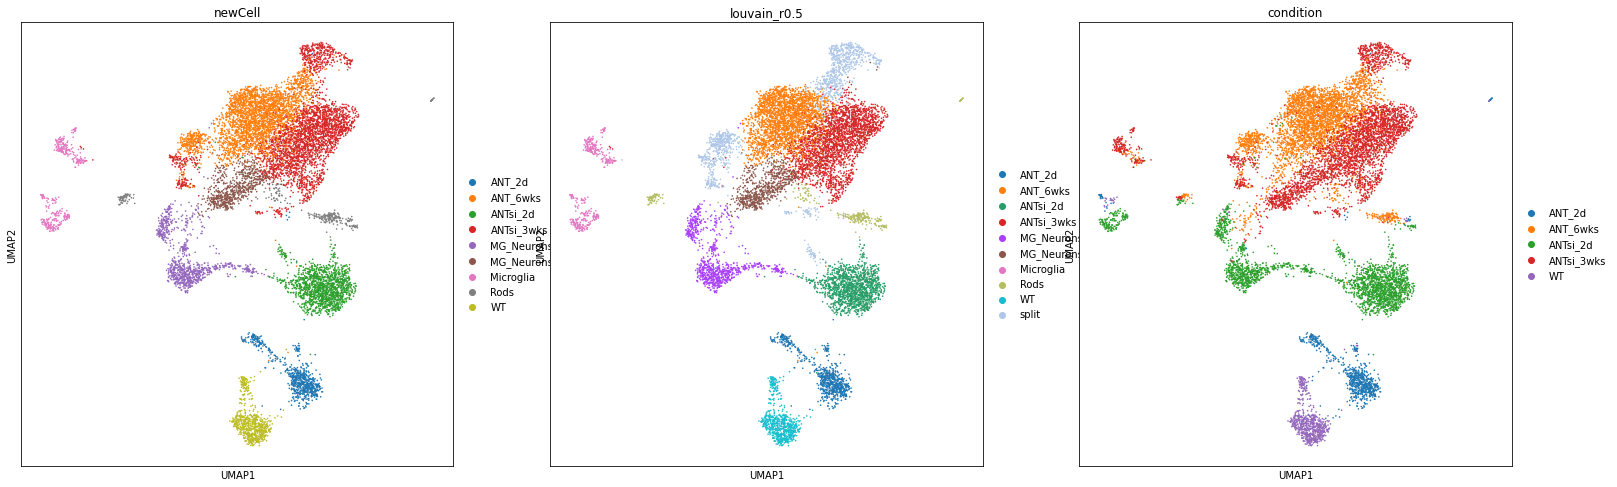

In [33]:
sc.pl.umap(adataJor, color = ['newCell', 'louvain_r0.5', 'condition'])

In [34]:
adataJor.obs.rename(columns={'louvain_r0.5':'oldCell'}, inplace=True)
adataJor.obs.rename(columns={'newCell':'louvain_r0.5'}, inplace=True)
adataJor.obs.drop(columns={'oldCell'}, inplace=True)

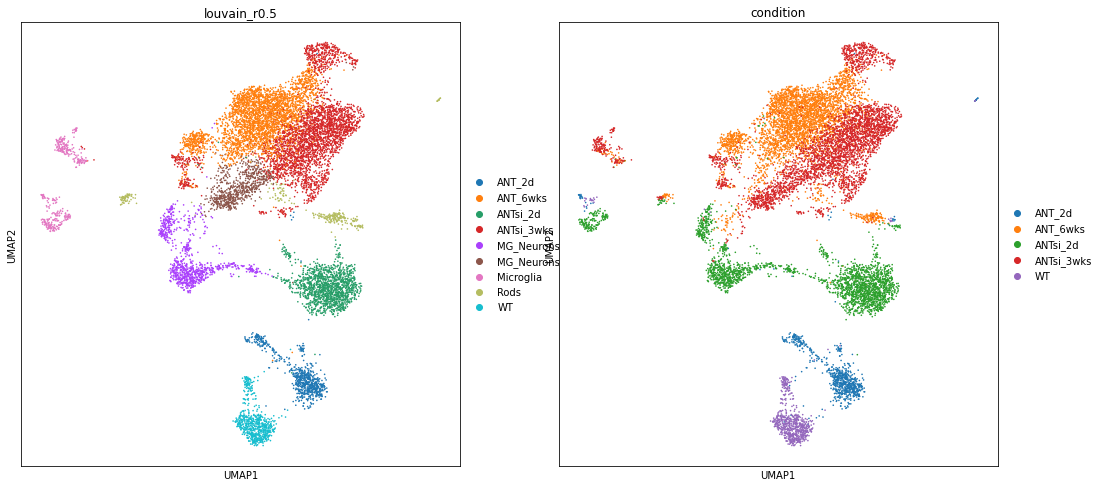

In [35]:
sc.pl.umap(adataJor, color = ['louvain_r0.5', 'condition'])

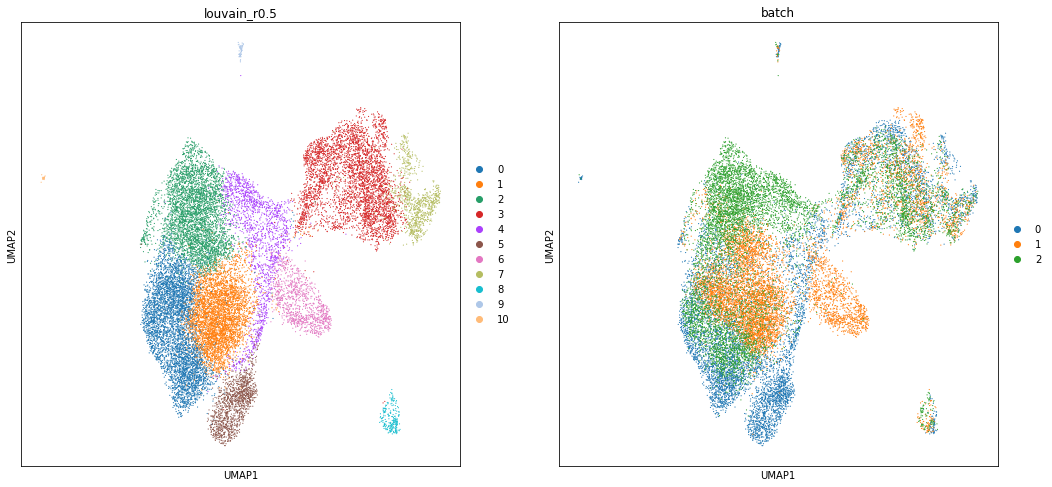

In [36]:
sc.pl.umap(adataR, color=['louvain_r0.5', 'batch'])


In [37]:
adataR.rename_categories('louvain_r0.5', ['NMDA_Control_2d','NMDA_Control1','NMDA_Control2','YAP5SA+_2d', 'NMDA_Control3', 'NMDA_Control4','NMDA_Control5','YAP5SA+2','Unclear_3','Unclear_1','Unclear_2'])

In [38]:
adataR.obs['louvain_r0.5'].replace({'NMDA_Control1':'NMDA_Control_2d', 'NMDA_Control2':'NMDA_Control_2d', 'NMDA_Control3':'NMDA_Control_2d', 'NMDA_Control4':'NMDA_Control_2d','NMDA_Control5':'NMDA_Control_2d',  'Unclear_1':'Unclear', 'Unclear_2':'Unclear', 'Unclear_3':'Unclear', 'YAP5SA+2':'YAP5SA+_2d', 'YAP5SA+_48hr':'YAP5SA+_2d'}, inplace=True)

... storing 'louvain_r0.5' as categorical


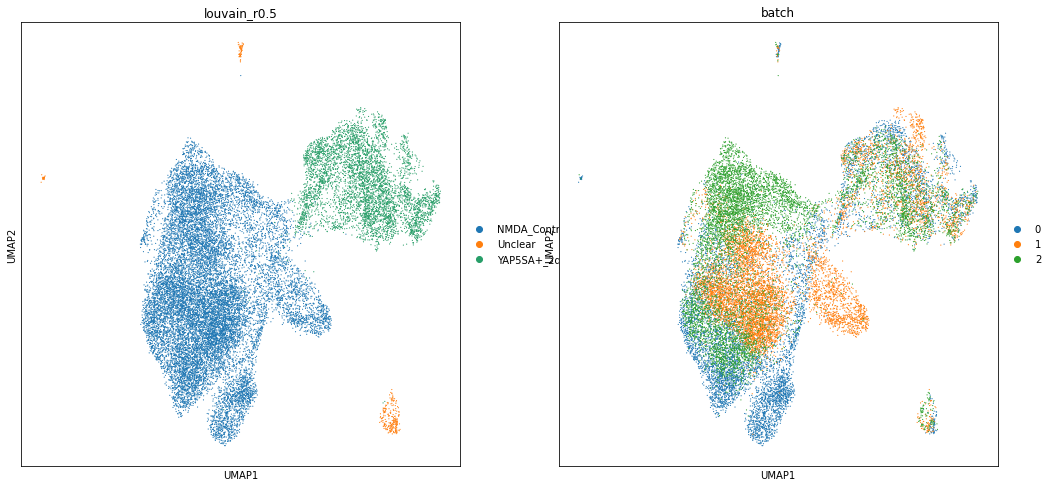

In [39]:
sc.pl.umap(adataR, color=['louvain_r0.5', 'batch'])


In [41]:
adataH.obs['louvain_r0.5'] = adataH.obs['condition'].copy()

In [42]:
adataH.obs['louvain_r0.5'].replace({'48hr NMDA':'NMDA_Control_2d', 'P60 R1':'WT', 'P60 R2':'WT'}, inplace=True)
#adataH.obs['louvain_r0.5'].replace({'NMDA_Control_48hr':'NMDA_Control_2d', 'P60 R1':'WT', 'P60 R2':'WT'}, inplace=True)


In [43]:
print(adataH.obs['louvain_r0.5'].value_counts())


3hr NMDA           1860
WT                 1319
6hr NMDA           1143
48hr NMDA+GF       1110
24hr NMDA           768
12hr NMDA           737
NMDA_Control_2d     727
72hr NMDA           607
36hr NMDA           567
Name: louvain_r0.5, dtype: int64


... storing 'batch' as categorical
... storing 'louvain_r0.5' as categorical


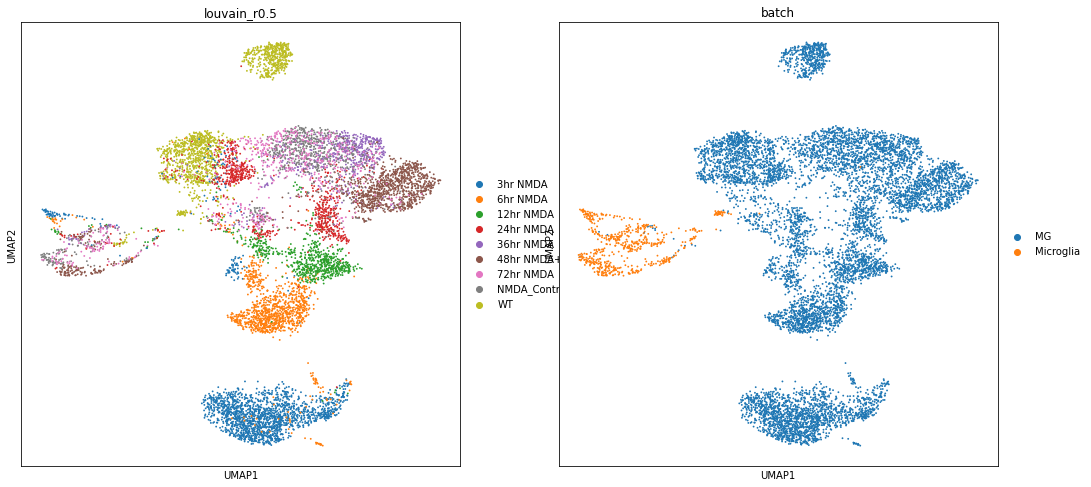

In [44]:
adataH.obs['batch'].replace({'0':'MG', '1':'Microglia'}, inplace=True)

sc.pl.umap(adataH, color=['louvain_r0.5', 'batch'])


In [45]:
adataH.obs

batch bimodel_counts bimodel_genes  condition  \
AAACCTGCAAGTACCT-0         MG         Peak 1        Peak 1     P60 R1   
AAAGCAAAGCCACGCT-0         MG         Peak 1        Peak 1     P60 R1   
AAAGCAACAGCCAATT-0         MG         Peak 1        Peak 1     P60 R1   
AAAGCAATCTGCTTGC-0         MG         Peak 1        Peak 1     P60 R1   
AACCATGTCCCATTTA-0         MG         Peak 1        Peak 1     P60 R1   
...                       ...            ...           ...        ...   
TGTCCCACAAGTCTGT-1  Microglia           None          None  72hr NMDA   
TTCGGTCCAGTCGATT-1  Microglia           None          None  72hr NMDA   
TTCTCAACATGGTAGG-1  Microglia           None          None  72hr NMDA   
TTCTTAGTCAACACTG-1  Microglia           None          None  72hr NMDA   
TTGAACGCATCTCGCT-1  Microglia           None          None  72hr NMDA   

                    dataset injury  log_counts   mt_frac  n_counts  n_genes  \
AAACCTGCAAGTACCT-0  Hoang20   NMDA    7.845416  0.086531    2554.0     1244   
AAAGCAAAGCCACGCT-0  Hoang20   NMDA    7.644919  0.067464    2090.0     1049   
AAAGCAACAGCCAATT-0  Hoang20   NMDA    7.968319  0.081717    2888.0     1291   
AAAGCAATCTGCTTGC-0  Hoang20   NMDA    7.795235  0.102511    2429.0     1186   
AACCATGTCCCATTTA-0  Hoang20   NMDA    8.014005  0.069798    3023.0     1369   
...                     ...    ...         ...       ...       ...      ...   
TGTCCCACAAGTCTGT-1  Hoang20   NMDA    9.073948  0.076332    8725.0     2466   
TTCGGTCCAGTCGATT-1  Hoang20   NMDA    7.636270  0.025097    2072.0     1073   
TTCTCAACATGGTAGG-1  Hoang20   NMDA    9.546598  0.033436   13997.0     2984   
TTCTTAGTCAACACTG-1  Hoang20   NMDA    8.931684  0.047437    7568.0     2254   
TTGAACGCATCTCGCT-1  Hoang20   NMDA    9.678279  0.063381   15967.0     3579   

                   species louvain_r0.5  
AAACCTGCAAGTACCT-0   Mouse           WT  
AAAGCAAAGCCACGCT-0   Mouse           WT  
AAAGCAACAGCCAATT-0   Mouse           WT  
AAAGCAATCTGCTTGC-0   Mouse           WT  
AACCATGTCCCATTTA-0   Mouse           WT  
...                    ...          ...  
TGTCCCACAAGTCTGT-1   Mouse    72hr NMDA  
TTCGGTCCAGTCGATT-1   Mouse    72hr NMDA  
TTCTCAACATGGTAGG-1   Mouse    72hr NMDA  
TTCTTAGTCAACACTG-1   Mouse    72hr NMDA  
TTGAACGCATCTCGCT-1   Mouse    72hr NMDA  

[8838 rows x 12 columns]

In [46]:
for i in range(8838):
    df = adataH.obs.iloc[[i]]
    cellname = list(df.index)
    cellname = cellname.pop(0)
    ds = df.loc[cellname, 'batch']
    if ds.startswith('Mic'):
        adataH.obs.loc[cellname, 'newLouvain'] = 'Microglia'
    else:
        adataH.obs.loc[cellname, 'newLouvain'] = adataH.obs.loc[cellname, 'louvain_r0.5']
    

In [47]:
adataH.obs.rename(columns={'louvain_r0.5': 'oldLouvain'}, inplace=True)
adataH.obs.rename(columns={'newLouvain': 'louvain_r0.5'}, inplace=True)


In [48]:
adataH.obs

batch bimodel_counts bimodel_genes  condition  \
AAACCTGCAAGTACCT-0         MG         Peak 1        Peak 1     P60 R1   
AAAGCAAAGCCACGCT-0         MG         Peak 1        Peak 1     P60 R1   
AAAGCAACAGCCAATT-0         MG         Peak 1        Peak 1     P60 R1   
AAAGCAATCTGCTTGC-0         MG         Peak 1        Peak 1     P60 R1   
AACCATGTCCCATTTA-0         MG         Peak 1        Peak 1     P60 R1   
...                       ...            ...           ...        ...   
TGTCCCACAAGTCTGT-1  Microglia           None          None  72hr NMDA   
TTCGGTCCAGTCGATT-1  Microglia           None          None  72hr NMDA   
TTCTCAACATGGTAGG-1  Microglia           None          None  72hr NMDA   
TTCTTAGTCAACACTG-1  Microglia           None          None  72hr NMDA   
TTGAACGCATCTCGCT-1  Microglia           None          None  72hr NMDA   

                    dataset injury  log_counts   mt_frac  n_counts  n_genes  \
AAACCTGCAAGTACCT-0  Hoang20   NMDA    7.845416  0.086531    2554.0     1244   
AAAGCAAAGCCACGCT-0  Hoang20   NMDA    7.644919  0.067464    2090.0     1049   
AAAGCAACAGCCAATT-0  Hoang20   NMDA    7.968319  0.081717    2888.0     1291   
AAAGCAATCTGCTTGC-0  Hoang20   NMDA    7.795235  0.102511    2429.0     1186   
AACCATGTCCCATTTA-0  Hoang20   NMDA    8.014005  0.069798    3023.0     1369   
...                     ...    ...         ...       ...       ...      ...   
TGTCCCACAAGTCTGT-1  Hoang20   NMDA    9.073948  0.076332    8725.0     2466   
TTCGGTCCAGTCGATT-1  Hoang20   NMDA    7.636270  0.025097    2072.0     1073   
TTCTCAACATGGTAGG-1  Hoang20   NMDA    9.546598  0.033436   13997.0     2984   
TTCTTAGTCAACACTG-1  Hoang20   NMDA    8.931684  0.047437    7568.0     2254   
TTGAACGCATCTCGCT-1  Hoang20   NMDA    9.678279  0.063381   15967.0     3579   

                   species oldLouvain louvain_r0.5  
AAACCTGCAAGTACCT-0   Mouse         WT           WT  
AAAGCAAAGCCACGCT-0   Mouse         WT           WT  
AAAGCAACAGCCAATT-0   Mouse         WT           WT  
AAAGCAATCTGCTTGC-0   Mouse         WT           WT  
AACCATGTCCCATTTA-0   Mouse         WT           WT  
...                    ...        ...          ...  
TGTCCCACAAGTCTGT-1   Mouse  72hr NMDA    Microglia  
TTCGGTCCAGTCGATT-1   Mouse  72hr NMDA    Microglia  
TTCTCAACATGGTAGG-1   Mouse  72hr NMDA    Microglia  
TTCTTAGTCAACACTG-1   Mouse  72hr NMDA    Microglia  
TTGAACGCATCTCGCT-1   Mouse  72hr NMDA    Microglia  

[8838 rows x 13 columns]

In [49]:
print(adataH.obs['louvain_r0.5'].value_counts())


3hr NMDA           1795
WT                 1261
6hr NMDA           1118
48hr NMDA+GF        958
24hr NMDA           731
12hr NMDA           709
NMDA_Control_2d     612
Microglia           597
36hr NMDA           536
72hr NMDA           521
Name: louvain_r0.5, dtype: int64


... storing 'louvain_r0.5' as categorical


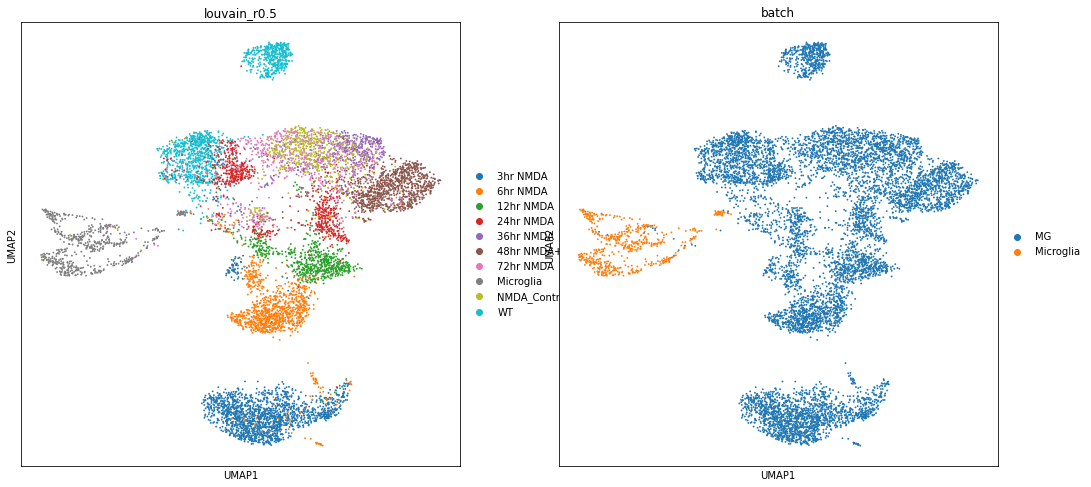

... storing 'batch' as categorical


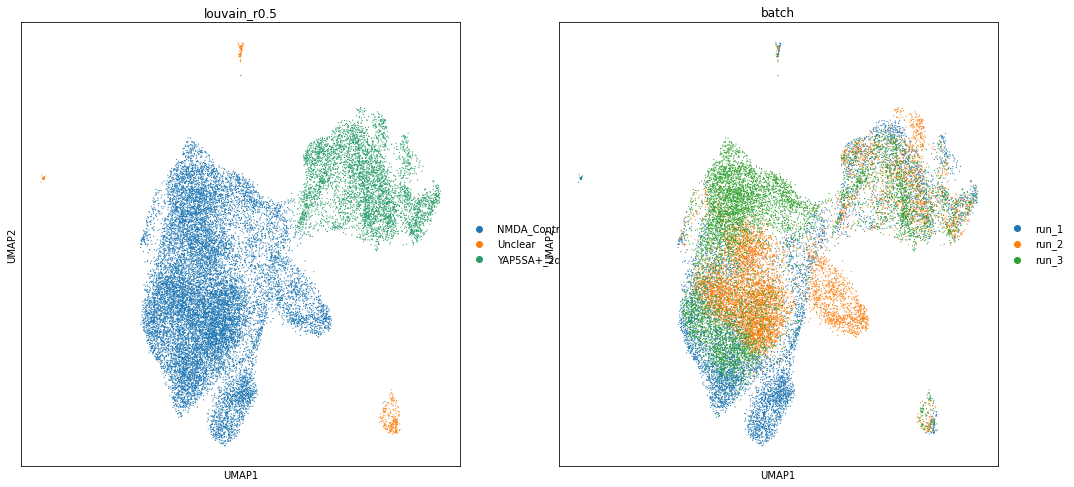

... storing 'batch' as categorical


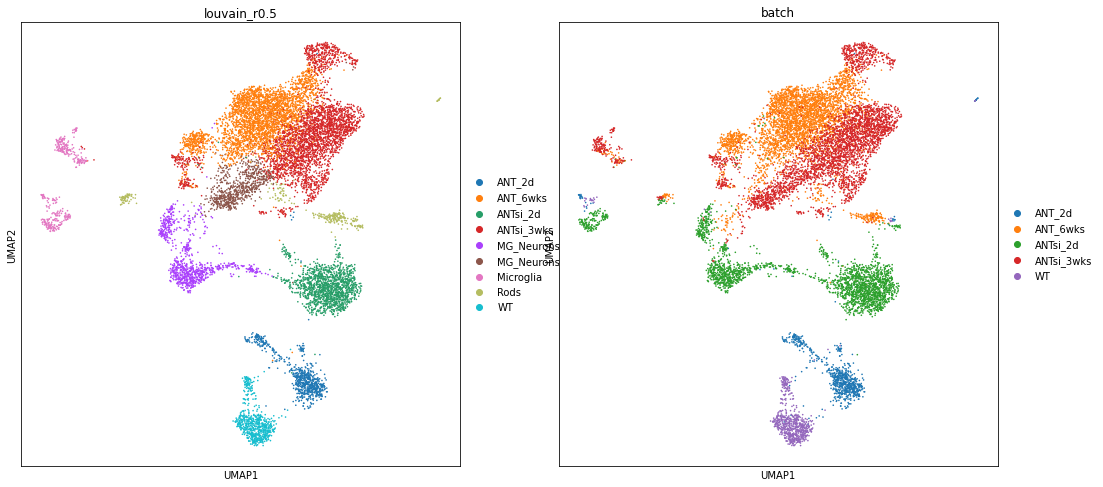

In [50]:
sc.pl.umap(adataH, color=['louvain_r0.5', 'batch'])
sc.pl.umap(adataR, color=['louvain_r0.5', 'batch'])
sc.pl.umap(adataJor, color=['louvain_r0.5', 'batch'])


In [51]:
adataR.obs['batch'].replace({'0':'run_1', '1':'run_2', '2':'run_3'}, inplace = True)
adataJor.obs['batch'].replace({'0':'ANT_2d', '1':'ANT_6wks', '2':'ANTsi_2d', '3':'ANTsi_3wks', '4':'WT'}, inplace=True)

In [52]:
#separate all anndatas for normalization
adataANT2d = adataJor[adataJor.obs["batch"] == "ANT_2d", :] 
adataANT6w = adataJor[adataJor.obs["batch"] == "ANT_6wks", :] 
adataANTsi2d = adataJor[adataJor.obs["batch"] == "ANTsi_2d", :] 
adataANTsi3w = adataJor[adataJor.obs["batch"] == "ANTsi_3wks", :] 
adataWT = adataJor[adataJor.obs["batch"] == "WT", :] 
adataR1 = adataR[adataR.obs["batch"] == "run_1", :] 
adataR2 = adataR[adataR.obs["batch"] == "run_2", :] 
adataR3 = adataR[adataR.obs["batch"] == "run_3", :] 
adataMG = adataH[adataH.obs["batch"] == "MG", :] 
adataMic = adataH[adataH.obs["batch"] == "Microglia", :] 

adatas3 = [adataANT2d, adataANT6w, adataANTsi2d, adataANTsi3w, adataWT, adataR1, adataR2, adataR3, adataMG, adataMic]

In [53]:
for adata in adatas3:
    del adata.uns['hvg']
    del adata.uns['pca']
    del adata.uns['neighbors']
    del adata.uns['umap']
    del adata.uns['louvain']
    #del adata.uns['rank_genes_r0.5']
    #del adata.uns['batch_colors']
    del adata.obsm['X_pca']
    del adata.obsm['X_umap']
    del adata.varm['PCs']
    del adata.obsp['distances']
    del adata.obsp['connectivities']
    del adata.var['highly_variable']
    del adata.var['means']
    del adata.var['dispersions']
    del adata.var['dispersions_norm']


In [54]:
for adata in adatas3:
    del adata.uns['hvg']
    del adata.uns['pca']
    del adata.uns['neighbors']
    del adata.uns['umap']
    del adata.uns['louvain']
    #del adata.uns['batch_colors']

In [55]:
adatas4 = [adataANT2d, adataANT6w, adataANTsi2d, adataANTsi3w, adataWT]
adatas5 = [adataR1, adataR2, adataR3]
adatas6 = [adataMG, adataMic]

In [56]:
for adata in adatas4:
   # del adata.uns['hvg']
    #del adata.uns['pca']
    #del adata.uns['neighbors']
   # del adata.uns['umap']
    #del adata.uns['louvain']
    del adata.uns['condition_colors'] 
    del adata.uns['batch_colors']
    
for adata in adatas5:
    #del adata.uns['hvg']
   # del adata.uns['pca']
  #  del adata.uns['neighbors']
  #  del adata.uns['umap']
  #  del adata.uns['louvain']
    del adata.uns['batch_colors']
    #del adata.uns['louvain_r0.5_colors']
    
for adata in adatas6:
    #del adata.uns['hvg']
#    del adata.uns['pca']
 #   del adata.uns['neighbors']
  #  del adata.uns['umap']
    #del adata.uns['louvain']
    del adata.uns['louvain_r0.5_colors']
    del adata.uns['batch_colors']


In [57]:
for adata in adatas3:
    print(adata)
    print('\n')

AnnData object with n_obs × n_vars = 805 × 17006
    obs: 'batch', 'bimodel_counts', 'bimodel_genes', 'condition', 'dataset', 'injury', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'species', 'louvain_r0.5'
    var: 'gene_id-0-0', 'n_cells-0-0', 'n_cells-1-0', 'gene_id-0-1-0', 'gene_id-1-1-0', 'gene_id-2-1-0', 'gene_id-2-0', 'n_cells-2-0', 'gene_id-3-0', 'n_cells-3-0', 'n_cells-4-0', 'gene_id-0-1', 'n_cells-0-1', 'n_cells-1-1', 'gene_id-0-1-1', 'gene_id-1-1-1', 'gene_id-2-1-1', 'gene_id-2-1', 'n_cells-2-1', 'gene_id-3-1', 'n_cells-3-1', 'n_cells-4-1', 'gene_id-0-2', 'n_cells-0-2', 'n_cells-1-2', 'gene_id-0-1-2', 'gene_id-1-1-2', 'gene_id-2-1-2', 'gene_id-2-2', 'n_cells-2-2', 'gene_id-3-2', 'n_cells-3-2', 'n_cells-4-2', 'gene_id-0-3', 'n_cells-0-3', 'n_cells-1-3', 'gene_id-0-1-3', 'gene_id-1-1-3', 'gene_id-2-1-3', 'gene_id-2-3', 'n_cells-2-3', 'gene_id-3-3', 'n_cells-3-3', 'n_cells-4-3', 'gene_id-0-4', 'n_cells-0-4', 'n_cells-1-4', 'gene_id-0-1-4', 'gene_id-1-1-4', 'gene_id-2-1-4', '

In [58]:
for adata in adatas3:
    print(adata.obs['batch'].value_counts())

ANT_2d    805
Name: batch, dtype: int64
ANT_6wks    3844
Name: batch, dtype: int64
ANTsi_2d    2562
Name: batch, dtype: int64
ANTsi_3wks    3634
Name: batch, dtype: int64
WT    700
Name: batch, dtype: int64
run_1    7117
Name: batch, dtype: int64
run_2    7911
Name: batch, dtype: int64
run_3    7696
Name: batch, dtype: int64
MG    8241
Name: batch, dtype: int64
Microglia    597
Name: batch, dtype: int64


In [59]:
adataMG.obs.drop(columns=['oldLouvain'], inplace = True)
adataMic.obs.drop(columns=['oldLouvain'], inplace = True)


In [60]:
adataANT2d.write('/Users/ann/2021/adata_h5ad/adata1_QC_N_UMAP.h5ad')
adataANT6w.write('/Users/ann/2021/adata_h5ad/adata2_QC_N_UMAP.h5ad')
adataANTsi2d.write('/Users/ann/2021/adata_h5ad/adata3_QC_N_UMAP.h5ad')
adataANTsi3w.write('/Users/ann/2021/adata_h5ad/adata4_QC_N_UMAP.h5ad')
adataWT.write('/Users/ann/2021/adata_h5ad/adata5_QC_N_UMAP.h5ad')
adataR1.write('/Users/ann/2021/adata_h5ad/adata6_QC_N_UMAP.h5ad')
adataR2.write('/Users/ann/2021/adata_h5ad/adata7_QC_N_UMAP.h5ad')
adataR3.write('/Users/ann/2021/adata_h5ad/adata8_QC_N_UMAP.h5ad')
adataMG.write('/Users/ann/2021/adata_h5ad/adata9_QC_N_UMAP.h5ad')
adataMic.write('/Users/ann/2021/adata_h5ad/adata10_QC_N_UMAP.h5ad')
 

In [60]:
adata = adataANT2d.concatenate(adataANT6w, adataANTsi2d, adataANTsi3w, adataWT, adataR1, adataR2, adataR3, adataMG, adataMic, join='outer')
adata.var.drop(columns=['gene_id-0-0-0', 'n_cells-0-0-0', 'n_cells-1-0-0', 'gene_id-0-1-0-0', 'gene_id-1-1-0-0', 'gene_id-2-1-0-0', 'gene_id-2-0-0', 'n_cells-2-0-0', 'gene_id-3-0-0', 'n_cells-3-0-0', 'n_cells-4-0-0', 'gene_id-0-1-0', 'n_cells-0-1-0', 'n_cells-1-1-0', 'gene_id-0-1-1-0', 'gene_id-1-1-1-0', 'gene_id-2-1-1-0', 'gene_id-2-1-0', 'n_cells-2-1-0', 'gene_id-3-1-0', 'n_cells-3-1-0', 'n_cells-4-1-0', 'gene_id-0-2-0', 'n_cells-0-2-0', 'n_cells-1-2-0', 'gene_id-0-1-2-0', 'gene_id-1-1-2-0', 'gene_id-2-1-2-0', 'gene_id-2-2-0', 'n_cells-2-2-0', 'gene_id-3-2-0', 'n_cells-3-2-0', 'n_cells-4-2-0', 'gene_id-0-3-0', 'n_cells-0-3-0', 'n_cells-1-3-0', 'gene_id-0-1-3-0', 'gene_id-1-1-3-0', 'gene_id-2-1-3-0', 'gene_id-2-3-0', 'n_cells-2-3-0', 'gene_id-3-3-0', 'n_cells-3-3-0', 'n_cells-4-3-0', 'gene_id-0-4-0', 'n_cells-0-4-0', 'n_cells-1-4-0', 'gene_id-0-1-4-0', 'gene_id-1-1-4-0', 'gene_id-2-1-4-0', 'gene_id-2-4-0', 'n_cells-2-4-0', 'gene_id-3-4-0', 'n_cells-3-4-0', 'n_cells-4-4-0', 'gene_id-0-0-1', 'n_cells-0-0-1', 'n_cells-1-0-1', 'gene_id-0-1-0-1', 'gene_id-1-1-0-1', 'gene_id-2-1-0-1', 'gene_id-2-0-1', 'n_cells-2-0-1', 'gene_id-3-0-1', 'n_cells-3-0-1', 'n_cells-4-0-1', 'gene_id-0-1-1', 'n_cells-0-1-1', 'n_cells-1-1-1', 'gene_id-0-1-1-1', 'gene_id-1-1-1-1', 'gene_id-2-1-1-1', 'gene_id-2-1-1', 'n_cells-2-1-1', 'gene_id-3-1-1', 'n_cells-3-1-1', 'n_cells-4-1-1', 'gene_id-0-2-1', 'n_cells-0-2-1', 'n_cells-1-2-1', 'gene_id-0-1-2-1', 'gene_id-1-1-2-1', 'gene_id-2-1-2-1', 'gene_id-2-2-1', 'n_cells-2-2-1', 'gene_id-3-2-1', 'n_cells-3-2-1', 'n_cells-4-2-1', 'gene_id-0-3-1', 'n_cells-0-3-1', 'n_cells-1-3-1', 'gene_id-0-1-3-1', 'gene_id-1-1-3-1', 'gene_id-2-1-3-1', 'gene_id-2-3-1', 'n_cells-2-3-1', 'gene_id-3-3-1', 'n_cells-3-3-1', 'n_cells-4-3-1', 'gene_id-0-4-1', 'n_cells-0-4-1', 'n_cells-1-4-1', 'gene_id-0-1-4-1', 'gene_id-1-1-4-1', 'gene_id-2-1-4-1', 'gene_id-2-4-1', 'n_cells-2-4-1', 'gene_id-3-4-1', 'n_cells-3-4-1', 'n_cells-4-4-1', 'gene_id-0-0-2', 'n_cells-0-0-2', 'n_cells-1-0-2', 'gene_id-0-1-0-2', 'gene_id-1-1-0-2', 'gene_id-2-1-0-2', 'gene_id-2-0-2', 'n_cells-2-0-2', 'gene_id-3-0-2', 'n_cells-3-0-2', 'n_cells-4-0-2', 'gene_id-0-1-2', 'n_cells-0-1-2', 'n_cells-1-1-2', 'gene_id-0-1-1-2', 'gene_id-1-1-1-2', 'gene_id-2-1-1-2', 'gene_id-2-1-2', 'n_cells-2-1-2', 'gene_id-3-1-2', 'n_cells-3-1-2', 'n_cells-4-1-2', 'gene_id-0-2-2', 'n_cells-0-2-2', 'n_cells-1-2-2', 'gene_id-0-1-2-2', 'gene_id-1-1-2-2', 'gene_id-2-1-2-2', 'gene_id-2-2-2', 'n_cells-2-2-2', 'gene_id-3-2-2', 'n_cells-3-2-2', 'n_cells-4-2-2', 'gene_id-0-3-2', 'n_cells-0-3-2', 'n_cells-1-3-2', 'gene_id-0-1-3-2', 'gene_id-1-1-3-2', 'gene_id-2-1-3-2', 'gene_id-2-3-2', 'n_cells-2-3-2', 'gene_id-3-3-2', 'n_cells-3-3-2', 'n_cells-4-3-2', 'gene_id-0-4-2', 'n_cells-0-4-2', 'n_cells-1-4-2', 'gene_id-0-1-4-2', 'gene_id-1-1-4-2', 'gene_id-2-1-4-2', 'gene_id-2-4-2', 'n_cells-2-4-2', 'gene_id-3-4-2', 'n_cells-3-4-2', 'n_cells-4-4-2', 'gene_id-0-0-3', 'n_cells-0-0-3', 'n_cells-1-0-3', 'gene_id-0-1-0-3', 'gene_id-1-1-0-3', 'gene_id-2-1-0-3', 'gene_id-2-0-3', 'n_cells-2-0-3', 'gene_id-3-0-3', 'n_cells-3-0-3', 'n_cells-4-0-3', 'gene_id-0-1-3', 'n_cells-0-1-3', 'n_cells-1-1-3', 'gene_id-0-1-1-3', 'gene_id-1-1-1-3', 'gene_id-2-1-1-3', 'gene_id-2-1-3', 'n_cells-2-1-3', 'gene_id-3-1-3', 'n_cells-3-1-3', 'n_cells-4-1-3', 'gene_id-0-2-3', 'n_cells-0-2-3', 'n_cells-1-2-3', 'gene_id-0-1-2-3', 'gene_id-1-1-2-3', 'gene_id-2-1-2-3', 'gene_id-2-2-3', 'n_cells-2-2-3', 'gene_id-3-2-3', 'n_cells-3-2-3', 'n_cells-4-2-3', 'gene_id-0-3-3', 'n_cells-0-3-3', 'n_cells-1-3-3', 'gene_id-0-1-3-3', 'gene_id-1-1-3-3', 'gene_id-2-1-3-3', 'gene_id-2-3-3', 'n_cells-2-3-3', 'gene_id-3-3-3', 'n_cells-3-3-3', 'n_cells-4-3-3', 'gene_id-0-4-3', 'n_cells-0-4-3', 'n_cells-1-4-3', 'gene_id-0-1-4-3', 'gene_id-1-1-4-3', 'gene_id-2-1-4-3', 'gene_id-2-4-3', 'n_cells-2-4-3', 'gene_id-3-4-3', 'n_cells-3-4-3', 'n_cells-4-4-3', 'gene_id-0-0-4', 'n_cells-0-0-4', 'n_cells-1-0-4', 'gene_id-0-1-0-4', 'gene_id-1-1-0-4', 'gene_id-2-1-0-4', 'gene_id-2-0-4', 'n_cells-2-0-4', 'gene_id-3-0-4', 'n_cells-3-0-4', 'n_cells-4-0-4', 'gene_id-0-1-4', 'n_cells-0-1-4', 'n_cells-1-1-4', 'gene_id-0-1-1-4', 'gene_id-1-1-1-4', 'gene_id-2-1-1-4', 'gene_id-2-1-4', 'n_cells-2-1-4', 'gene_id-3-1-4', 'n_cells-3-1-4', 'n_cells-4-1-4', 'gene_id-0-2-4', 'n_cells-0-2-4', 'n_cells-1-2-4', 'gene_id-0-1-2-4', 'gene_id-1-1-2-4', 'gene_id-2-1-2-4', 'gene_id-2-2-4', 'n_cells-2-2-4', 'gene_id-3-2-4', 'n_cells-3-2-4', 'n_cells-4-2-4', 'gene_id-0-3-4', 'n_cells-0-3-4', 'n_cells-1-3-4', 'gene_id-0-1-3-4', 'gene_id-1-1-3-4', 'gene_id-2-1-3-4', 'gene_id-2-3-4', 'n_cells-2-3-4', 'gene_id-3-3-4', 'n_cells-3-3-4', 'n_cells-4-3-4', 'gene_id-0-4-4', 'n_cells-0-4-4', 'n_cells-1-4-4', 'gene_id-0-1-4-4', 'gene_id-1-1-4-4', 'gene_id-2-1-4-4', 'gene_id-2-4-4', 'n_cells-2-4-4', 'gene_id-3-4-4', 'n_cells-3-4-4', 'n_cells-4-4-4', 'gene_id-0-0-5', 'n_cells-0-0-5', 'n_cells-1-0-5', 'gene_id-0-1-0-5', 'gene_id-1-1-0-5', 'gene_id-2-1-0-5', 'gene_id-2-0-5', 'n_cells-2-0-5', 'gene_id-3-0-5', 'n_cells-3-0-5', 'n_cells-4-0-5', 'gene_id-0-1-5', 'n_cells-0-1-5', 'n_cells-1-1-5', 'gene_id-0-1-1-5', 'gene_id-1-1-1-5', 'gene_id-2-1-1-5', 'gene_id-2-1-5', 'n_cells-2-1-5', 'gene_id-3-1-5', 'n_cells-3-1-5', 'n_cells-4-1-5', 'gene_id-0-2-5', 'n_cells-0-2-5', 'n_cells-1-2-5', 'gene_id-0-1-2-5', 'gene_id-1-1-2-5', 'gene_id-2-1-2-5', 'gene_id-2-2-5', 'n_cells-2-2-5', 'gene_id-3-2-5', 'n_cells-3-2-5', 'n_cells-4-2-5', 'gene_id-0-0-6', 'n_cells-0-0-6', 'n_cells-1-0-6', 'gene_id-0-1-0-6', 'gene_id-1-1-0-6', 'gene_id-2-1-0-6', 'gene_id-2-0-6', 'n_cells-2-0-6', 'gene_id-3-0-6', 'n_cells-3-0-6', 'n_cells-4-0-6', 'gene_id-0-1-6', 'n_cells-0-1-6', 'n_cells-1-1-6', 'gene_id-0-1-1-6', 'gene_id-1-1-1-6', 'gene_id-2-1-1-6', 'gene_id-2-1-6', 'n_cells-2-1-6', 'gene_id-3-1-6', 'n_cells-3-1-6', 'n_cells-4-1-6', 'gene_id-0-2-6', 'n_cells-0-2-6', 'n_cells-1-2-6', 'gene_id-0-1-2-6', 'gene_id-1-1-2-6', 'gene_id-2-1-2-6', 'gene_id-2-2-6', 'n_cells-2-2-6', 'gene_id-3-2-6', 'n_cells-3-2-6', 'n_cells-4-2-6', 'gene_id-0-0-7', 'n_cells-0-0-7', 'n_cells-1-0-7', 'gene_id-0-1-0-7', 'gene_id-1-1-0-7', 'gene_id-2-1-0-7', 'gene_id-2-0-7', 'n_cells-2-0-7', 'gene_id-3-0-7', 'n_cells-3-0-7', 'n_cells-4-0-7', 'gene_id-0-1-7', 'n_cells-0-1-7', 'n_cells-1-1-7', 'gene_id-0-1-1-7', 'gene_id-1-1-1-7', 'gene_id-2-1-1-7', 'gene_id-2-1-7', 'n_cells-2-1-7', 'gene_id-3-1-7', 'n_cells-3-1-7', 'n_cells-4-1-7', 'gene_id-0-2-7', 'n_cells-0-2-7', 'n_cells-1-2-7', 'gene_id-0-1-2-7', 'gene_id-1-1-2-7', 'gene_id-2-1-2-7', 'gene_id-2-2-7', 'n_cells-2-2-7', 'gene_id-3-2-7', 'n_cells-3-2-7', 'n_cells-4-2-7', 'gene_id-0-0-8', 'n_cells-0-0-8', 'n_cells-1-0-8', 'gene_id-0-1-0-8', 'gene_id-1-1-0-8', 'gene_id-2-1-0-8', 'gene_id-2-0-8', 'n_cells-2-0-8', 'gene_id-3-0-8', 'n_cells-3-0-8', 'n_cells-4-0-8', 'gene_id-0-1-8', 'n_cells-0-1-8', 'n_cells-1-1-8', 'gene_id-0-1-1-8', 'gene_id-1-1-1-8', 'gene_id-2-1-1-8', 'gene_id-2-1-8', 'n_cells-2-1-8', 'gene_id-3-1-8', 'n_cells-3-1-8', 'n_cells-4-1-8', 'gene_id-0-0-9', 'n_cells-0-0-9', 'n_cells-1-0-9', 'gene_id-0-1-0-9', 'gene_id-1-1-0-9', 'gene_id-2-1-0-9', 'gene_id-2-0-9', 'n_cells-2-0-9', 'gene_id-3-0-9', 'n_cells-3-0-9', 'n_cells-4-0-9', 'gene_id-0-1-9', 'n_cells-0-1-9', 'n_cells-1-1-9', 'gene_id-0-1-1-9', 'gene_id-1-1-1-9', 'gene_id-2-1-1-9', 'gene_id-2-1-9', 'n_cells-2-1-9', 'gene_id-3-1-9', 'n_cells-3-1-9', 'n_cells-4-1-9'], inplace = True)
adata.obs['louvain_r0.5'].value_counts()

/Users/ann/opt/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:794: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  value_idx = self._prep_dim_index(value.index, attr)


NMDA_Control_2d        18022
YAP5SA+_2d              5003
ANT_6wks                3197
ANTsi_3wks              3088
WT                      1944
3hr NMDA                1795
ANTsi_2d                1502
6hr NMDA                1118
Microglia                979
48hr NMDA+GF             958
MG_Neurons_ANTsi2d       940
ANT_2d                   737
24hr NMDA                731
MG_Neurons_ANTsi3wk      713
12hr NMDA                709
36hr NMDA                536
72hr NMDA                521
Unclear                  311
Rods                     303
Name: louvain_r0.5, dtype: int64

In [61]:
adata.obs['batch'].value_counts()

8    8241
6    7911
7    7696
5    7117
1    3844
3    3634
2    2562
0     805
4     700
9     597
Name: batch, dtype: int64

In [62]:
adata.obs['n_genes'] = (adata.X > 0).sum(1) # recompute number of genes expressed per cell

In [63]:
adata

AnnData object with n_obs × n_vars = 43107 × 17006
    obs: 'batch', 'bimodel_counts', 'bimodel_genes', 'condition', 'dataset', 'injury', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'species', 'louvain_r0.5'
    layers: 'counts'

In [64]:
#cell types

YAP5SA = adata[adata.obs["louvain_r0.5"] == "YAP5SA+_2d", :] #1
Neurons_ANTsi2d = adata[adata.obs["louvain_r0.5"] == "MG_Neurons_ANTsi2d", :] #3
ANTsi2d = adata[adata.obs["louvain_r0.5"] == "ANTsi_2d", :] #6

#Neurons_ANTsi3wks = adata[adata.obs["louvain_r0.5"] == "MG_Neurons_ANTsi3wks", :] #2
#ANT2d = adata[adata.obs["louvain_r0.5"] == "ANT_2d", :] #4
#ANT6wks = adata[adata.obs["louvain_r0.5"] == "ANT_6wks", :] #5
#ANTsi3wks = adata[adata.obs["louvain_r0.5"] == "ANTsi_3wks", :] #7

NMDA_Control_2d = adata[adata.obs["louvain_r0.5"] == "NMDA_Control_2d", :] #8
WT = adata[adata.obs["louvain_r0.5"] == "WT", :] #9

adatas4 = [YAP5SA, Neurons_ANTsi2d, ANTsi2d, NMDA_Control_2d, WT]


In [65]:
YAPwt = YAP5SA.concatenate(WT)
ANTSIwt = ANTsi2d.concatenate(WT)
NEUwt = Neurons_ANTsi2d.concatenate(WT)
YAPnmda = YAP5SA.concatenate(NMDA_Control_2d)
ANTSInmda = ANTsi2d.concatenate(NMDA_Control_2d)
NEUnmda = Neurons_ANTsi2d.concatenate(NMDA_Control_2d)

YAP_ANTSI = YAP5SA.concatenate(ANTsi2d)
ANTSI_NEU = ANTsi2d.concatenate(Neurons_ANTsi2d)
NEU_YAP = Neurons_ANTsi2d.concatenate(YAP5SA)

DEadata = [YAPwt, ANTSIwt, NEUwt, YAPnmda, ANTSInmda, NEUnmda, YAP_ANTSI, ANTSI_NEU, NEU_YAP]

In [79]:
NMDA_Control_2d.obs

batch bimodel_counts bimodel_genes  condition  \
run1_AAACCTGAGAGTAATC-0-5     5           None          None     YAP5SA   
run1_AAACCTGAGCACCGCT-0-5     5           None          None     YAP5SA   
run1_AAACCTGAGGGCTTCC-0-5     5           None          None     YAP5SA   
run1_AAACCTGAGTACCGGA-0-5     5           None          None     YAP5SA   
run1_AAACCTGAGTTCGCGC-0-5     5           None          None     YAP5SA   
...                         ...            ...           ...        ...   
TTTACTGTCAGTCAGT-0-8          8         Peak 2        Peak 2  48hr NMDA   
TTTGCGCAGGGTGTGT-0-8          8         Peak 2        Peak 1  48hr NMDA   
TTTGCGCTCTGGCGAC-0-8          8         Peak 2        Peak 2  48hr NMDA   
TTTGGTTCATGCCTTC-0-8          8         Peak 2        Peak 2  48hr NMDA   
TTTGGTTTCTAACGGT-0-8          8         Peak 2        Peak 2  48hr NMDA   

                           dataset injury  log_counts   mt_frac  n_counts  \
run1_AAACCTGAGAGTAATC-0-5    Rueda   NMDA    8.952476  0.073379    7727.0   
run1_AAACCTGAGCACCGCT-0-5    Rueda   NMDA    8.570165  0.063543    5272.0   
run1_AAACCTGAGGGCTTCC-0-5    Rueda   NMDA    9.767782  0.050796   17462.0   
run1_AAACCTGAGTACCGGA-0-5    Rueda   NMDA    9.880679  0.060566   19549.0   
run1_AAACCTGAGTTCGCGC-0-5    Rueda   NMDA    9.715108  0.040927   16566.0   
...                            ...    ...         ...       ...       ...   
TTTACTGTCAGTCAGT-0-8       Hoang20   NMDA    8.927314  0.062508    7535.0   
TTTGCGCAGGGTGTGT-0-8       Hoang20   NMDA    9.019906  0.088435    8266.0   
TTTGCGCTCTGGCGAC-0-8       Hoang20   NMDA    9.588161  0.050374   14591.0   
TTTGGTTCATGCCTTC-0-8       Hoang20   NMDA    9.263597  0.045131   10547.0   
TTTGGTTTCTAACGGT-0-8       Hoang20   NMDA    9.253592  0.068761   10442.0   

                           n_genes species     louvain_r0.5 louvain2  
run1_AAACCTGAGAGTAATC-0-5     2483   Mouse  NMDA_Control_2d  control  
run1_AAACCTGAGCACCGCT-0-5     2077   Mouse  NMDA_Control_2d  control  
run1_AAACCTGAGGGCTTCC-0-5     4312   Mouse  NMDA_Control_2d  control  
run1_AAACCTGAGTACCGGA-0-5     4734   Mouse  NMDA_Control_2d  control  
run1_AAACCTGAGTTCGCGC-0-5     3726   Mouse  NMDA_Control_2d  control  
...                            ...     ...              ...      ...  
TTTACTGTCAGTCAGT-0-8          2521   Mouse  NMDA_Control_2d  control  
TTTGCGCAGGGTGTGT-0-8          2191   Mouse  NMDA_Control_2d  control  
TTTGCGCTCTGGCGAC-0-8          3477   Mouse  NMDA_Control_2d  control  
TTTGGTTCATGCCTTC-0-8          3221   Mouse  NMDA_Control_2d  control  
TTTGGTTTCTAACGGT-0-8          2904   Mouse  NMDA_Control_2d  control  

[18022 rows x 13 columns]

In [80]:
YAP5SA3 = YAP5SA[YAP5SA.obs["batch"] == '7', :]
NMDA_Control_2d3 = NMDA_Control_2d[NMDA_Control_2d.obs["batch"] == '7', :]
NMDA_Control_2d4 = NMDA_Control_2d[NMDA_Control_2d.obs["batch"] == '8', :]

YAP_ANTSI = YAP5SA3.concatenate(ANTsi2d)
NEU_YAP = Neurons_ANTsi2d.concatenate(YAP5SA3)

YAPnmda = YAP5SA3.concatenate(NMDA_Control_2d3, NMDA_Control_2d4)
ANTSInmda = ANTsi2d.concatenate(NMDA_Control_2d3, NMDA_Control_2d4)
NEUnmda = Neurons_ANTsi2d.concatenate(NMDA_Control_2d3, NMDA_Control_2d4)

YAP_ANTSI.obs['louvain2'] = 'regen'
NMDA_Control_2d3.obs['louvain2'] = 'control'
NMDA_Control_2d4.obs['louvain2'] = 'control'
YAP_ANTSI_NMDA = YAP_ANTSI.concatenate(NMDA_Control_2d3, NMDA_Control_2d4)

/Users/ann/opt/miniconda3/lib/python3.8/site-packages/anndata/_core/merge.py:810: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  concat_annot = pd.concat(
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [67]:
%%R -i YAPnmda

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(YAPnmda, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)


In [68]:
%%R

zlmCond <- zlm(formula = ~louvain_r0.5 + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5YAP5SA+_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5YAP5SA+_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5YAP5SA+_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
YAP_nmda_de = result_de[order(result_de$FDR),]

write.csv(YAP_nmda_de,"/Users/ann/2021/new_DEGs/_YAP5SA_vNMDAcontrol.csv")

In [ ]:
%%R -i ANTSInmda

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(ANTSInmda, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5NMDA_Control_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NMDA_antsi_de = result_de[order(result_de$FDR),]

write.csv(NMDA_antsi_de,"/Users/ann/2021/new_DEGs/_NMDAcontrol_vANTsi2d.csv")


In [ ]:
%%R -i NEUnmda

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(NEUnmda, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5NMDA_Control_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NMDA_neurons_de = result_de[order(result_de$FDR),]

write.csv(NMDA_neurons_de,"/Users/ann/2021/new_DEGs/_NMDAcontrol_vNeuronsANTsi2d.csv")


In [89]:
%%R -i YAP_ANTSI

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(YAP_ANTSI, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5YAP5SA+_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5YAP5SA+_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5YAP5SA+_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
YAP_antsi_de = result_de[order(result_de$FDR),]

#write.csv(YAP_antsi_de,"/Users/ann/2021/new_DEGs/_YAP5SA_vANTsi2d.csv")
write.csv(YAP_antsi_de,"/Users/ann/2021/new_DEGs/_YAP5SA_vANTsi2dV2.csv")


In [ ]:
%%R -i ANTSI_NEU

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(ANTSI_NEU, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5MG_Neurons_ANTsi2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5MG_Neurons_ANTsi2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5MG_Neurons_ANTsi2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NEU_antsi_de = result_de[order(result_de$FDR),]

write.csv(NEU_antsi_de,"/Users/ann/2021/new_DEGs/_NeuronsANTsi2d_vANTsi2d.csv")
#write.csv(NEU_antsi_de,"/Users/ann/2021/new_DEGs/_NeuronsANTsi2d_vANTsi2dV2.csv")


In [90]:
%%R -i NEU_YAP

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(NEU_YAP, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5YAP5SA+_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5YAP5SA+_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5YAP5SA+_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
YAP_neurons_de = result_de[order(result_de$FDR),]

#write.csv(YAP_neurons_de,"/Users/ann/2021/new_DEGs/_YAP5SA_vNeuronsANTsi2d.csv")
write.csv(YAP_neurons_de,"/Users/ann/2021/new_DEGs/_YAP5SA_vNeuronsANTsi2dV2.csv")


In [67]:
NMDA3H = adata[adata.obs["louvain_r0.5"] == "3hr NMDA", :]
NMDAx2 = NMDA3H.concatenate(NMDA_Control_2d)

YAP_ANTSI.obs['louvain2'] = 'regen'
NMDA_Control_2d.obs['louvain2'] = 'control'
YAP_ANTSI_NMDA = YAP_ANTSI.concatenate(NMDA_Control_2d)

Trying to set attribute `.obs` of view, copying.


In [67]:
%%R -i NMDAx2

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(NMDAx2, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5NMDA_Control_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NMDA2d_nmda3h_de = result_de[order(result_de$FDR),]

write.csv(NMDA2d_nmda3h_de,"/Users/ann/2021/new_DEGs/_NMDA2d_vNmda3h.csv")


In [87]:
NMDA_Control_2d3

AnnData object with n_obs × n_vars = 5892 × 17006
    obs: 'batch', 'bimodel_counts', 'bimodel_genes', 'condition', 'dataset', 'injury', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'species', 'louvain_r0.5', 'louvain2'
    layers: 'counts'

In [86]:
YAP_ANTSI_NMDA.obs

batch bimodel_counts bimodel_genes  condition  \
run3_AAACCTGGTACACCGC-2-7-0-0     0           None          None     YAP5SA   
run3_AAACCTGTCAGGTTCA-2-7-0-0     0           None          None     YAP5SA   
run3_AAACCTGTCTTCATGT-2-7-0-0     0           None          None     YAP5SA   
run3_AAACGGGAGACGCAAC-2-7-0-0     0           None          None     YAP5SA   
run3_AAACGGGAGTGTGGCA-2-7-0-0     0           None          None     YAP5SA   
...                             ...            ...           ...        ...   
TTTACTGTCAGTCAGT-0-8-2            2         Peak 2        Peak 2  48hr NMDA   
TTTGCGCAGGGTGTGT-0-8-2            2         Peak 2        Peak 1  48hr NMDA   
TTTGCGCTCTGGCGAC-0-8-2            2         Peak 2        Peak 2  48hr NMDA   
TTTGGTTCATGCCTTC-0-8-2            2         Peak 2        Peak 2  48hr NMDA   
TTTGGTTTCTAACGGT-0-8-2            2         Peak 2        Peak 2  48hr NMDA   

                               dataset injury  log_counts   mt_frac  n_counts  \
run3_AAACCTGGTACACCGC-2-7-0-0    Rueda   NMDA    9.815039  0.041296   18307.0   
run3_AAACCTGTCAGGTTCA-2-7-0-0    Rueda   NMDA    9.803501  0.045864   18097.0   
run3_AAACCTGTCTTCATGT-2-7-0-0    Rueda   NMDA    9.499496  0.061934   13353.0   
run3_AAACGGGAGACGCAAC-2-7-0-0    Rueda   NMDA    8.716864  0.030467    6105.0   
run3_AAACGGGAGTGTGGCA-2-7-0-0    Rueda   NMDA    8.600799  0.064753    5436.0   
...                                ...    ...         ...       ...       ...   
TTTACTGTCAGTCAGT-0-8-2         Hoang20   NMDA    8.927314  0.062508    7535.0   
TTTGCGCAGGGTGTGT-0-8-2         Hoang20   NMDA    9.019906  0.088435    8266.0   
TTTGCGCTCTGGCGAC-0-8-2         Hoang20   NMDA    9.588161  0.050374   14591.0   
TTTGGTTCATGCCTTC-0-8-2         Hoang20   NMDA    9.263597  0.045131   10547.0   
TTTGGTTTCTAACGGT-0-8-2         Hoang20   NMDA    9.253592  0.068761   10442.0   

                               n_genes species     louvain_r0.5 louvain2  
run3_AAACCTGGTACACCGC-2-7-0-0     4068   Mouse       YAP5SA+_2d    regen  
run3_AAACCTGTCAGGTTCA-2-7-0-0     3797   Mouse       YAP5SA+_2d    regen  
run3_AAACCTGTCTTCATGT-2-7-0-0     3801   Mouse       YAP5SA+_2d    regen  
run3_AAACGGGAGACGCAAC-2-7-0-0     1907   Mouse       YAP5SA+_2d    regen  
run3_AAACGGGAGTGTGGCA-2-7-0-0     2575   Mouse       YAP5SA+_2d    regen  
...                                ...     ...              ...      ...  
TTTACTGTCAGTCAGT-0-8-2            2521   Mouse  NMDA_Control_2d  control  
TTTGCGCAGGGTGTGT-0-8-2            2191   Mouse  NMDA_Control_2d  control  
TTTGCGCTCTGGCGAC-0-8-2            3477   Mouse  NMDA_Control_2d  control  
TTTGGTTCATGCCTTC-0-8-2            3221   Mouse  NMDA_Control_2d  control  
TTTGGTTTCTAACGGT-0-8-2            2904   Mouse  NMDA_Control_2d  control  

[9711 rows x 13 columns]

In [88]:
%%R -i YAP_ANTSI_NMDA

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(YAP_ANTSI_NMDA, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain2 <- as.factor(colData(sca)$louvain2)

zlmCond <- zlm(formula = ~louvain2 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain2regen')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain2regen' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain2regen' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
REGEN_control_de = result_de[order(result_de$FDR),]

write.csv(REGEN_control_de,"/Users/ann/2021/new_DEGs/_YAP+ANTSI_vNmda2dcontrol.csv")


In [ ]:
%%R -i adata

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5NMDA_Control_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NMDA_4_de = result_de[order(result_de$FDR),]

write.csv(NMDA_4_de,"/Users/ann/2021/new_DEGs/_NMDAcontrol_vANT2d.csv")


In [ ]:
%%R -i adata

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5NMDA_Control_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NMDA_4_de = result_de[order(result_de$FDR),]

write.csv(NMDA_4_de,"/Users/ann/2021/new_DEGs/_NMDAcontrol_vANT2d.csv")


In [ ]:
%%R -i adata

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

colData(sca)$louvain_r0.5 <- as.factor(colData(sca)$louvain_r0.5)

zlmCond <- zlm(formula = ~louvain_r0.5 + dataset + n_genes, sca=sca)
summaryCond <- summary(zlmCond, doLRT='louvain_r0.5NMDA_Control_2d')
summaryDt <- summaryCond$datatable

result <- merge(summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt[contrast=='louvain_r0.5NMDA_Control_2d' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result_de = result[result$FDR<0.01,, drop=F]
NMDA_4_de = result_de[order(result_de$FDR),]

write.csv(NMDA_4_de,"/Users/ann/2021/new_DEGs/_NMDAcontrol_vANT2d.csv")
